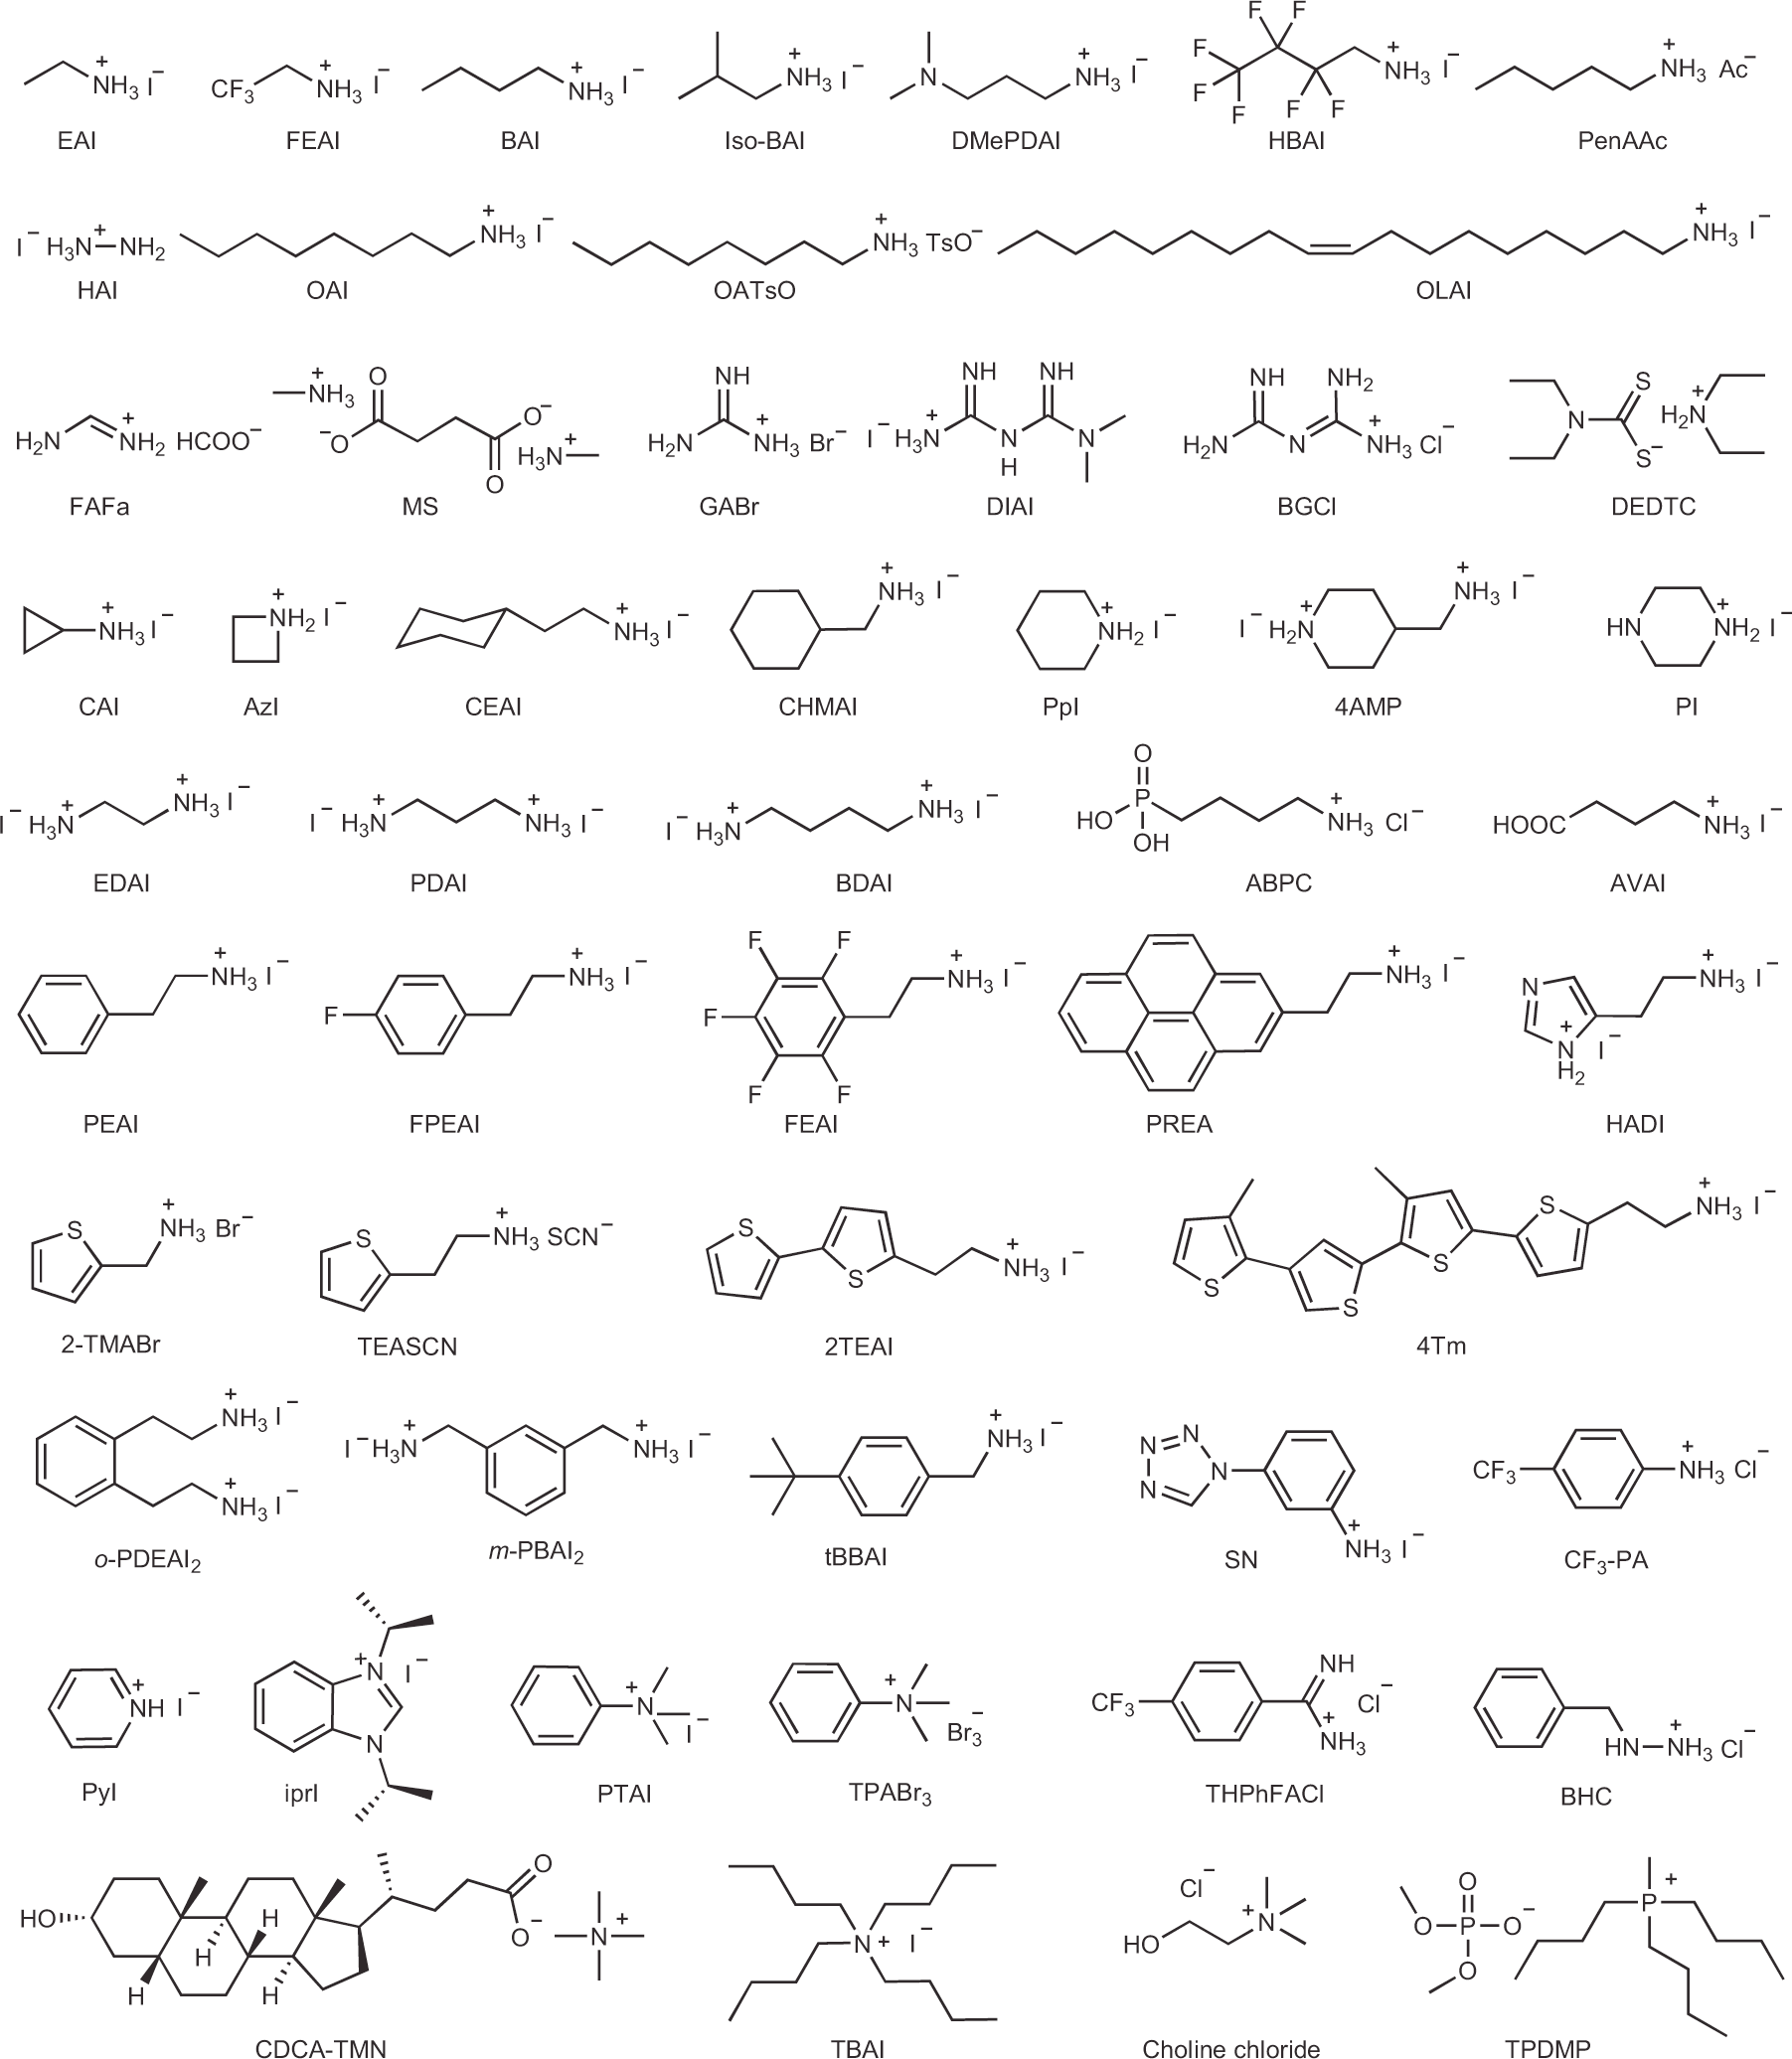

In [ ]:
from ase import Atoms, io
from ase.build import sort
from ase.neighborlist import NeighborList
from ase.visualize import *
from ase import Atoms
from ase import io
from ase.io import *
from ase.io.cif import read_cif
from ase.io.vasp import write_vasp
from ase.visualize.plot import plot_atoms
from ase.build import add_adsorbate
from ase.io.proteindatabank import read_proteindatabank, write_proteindatabank
from ase.io.lammpsdata import write_lammps_data
from ase.build import bulk, surface
from ase.build.tools import sort
import random
from ase.io import read, write
from ase.build import molecule
from ase.atoms import Atoms
from ase.neighborlist import NeighborList
import random

def load_structure(cif_file):
    """Load and sort the crystal structure."""
    structure = io.read(cif_file)
    structure = structure.repeat((2,3,5))
    return sort(structure)

def replace_fa(structure, fa_file):
    """Replace FA in the unit cell with the provided FA molecule."""
    tmp_molecule=[]
    j = 0

    # Prepare to store indices of atoms to delete
    del_indices = []

    # Iterate over atoms in the structure
    for i, symbol in enumerate(structure.get_chemical_symbols()):
        # Load the FA molecule
        fa_molecule = io.read(fa_file)
        fa_molecule.set_cell(structure.cell)

        if symbol == 'C':
            # Mark carbon atom for deletion
            del_indices.append(i)
            
            # Calculate new positions for FA molecule
            fa_molecule.positions += (structure.positions[i] - fa_molecule.get_center_of_mass())
            if j==0: 
                tmp_molecule = fa_molecule 
            else:
                tmp_molecule += fa_molecule
            j = j+1

    # Also mark nitrogen atoms for deletion
    del_indices.extend(i for i, symbol in enumerate(structure.get_chemical_symbols()) if symbol == 'N')

    # Remove specified atoms from the structure
    structure = structure.copy()  # Avoid modifying in place
    del structure[del_indices]

    # Combine the updated structure with the FA molecule
    FA_replaced_structure = sort(structure + tmp_molecule)

    return FA_replaced_structure

def replace_species(structure, replacements):
    """Replace specified species in the structure."""
    for symbol, new_symbol, count in replacements:
        indices = [i for i, atom in enumerate(structure) if atom.symbol == symbol]
        for i in range(min(count, len(indices))):
            structure.symbols[indices[i]] = new_symbol

# function to replace randomly 
def replace_species_random(structure, replacements):
    """Randomly replace specified species in the structure."""
    for symbol, new_symbol, count in replacements:
        # Find all indices of the specified symbol
        indices = [i for i, atom in enumerate(structure) if atom.symbol == symbol]

        # Select a random sample of indices to replace
        num_to_replace = min(count, len(indices))
        if num_to_replace > 0:
            random_indices = random.sample(indices, num_to_replace)

            # Replace the selected indices with the new symbol
            for idx in random_indices:
                structure.symbols[idx] = new_symbol

def random_replace(structure, species, new_symbol, num_replacements, cutoff_distance):
    """Randomly replace specified species and remove neighboring atoms."""
    nl = NeighborList([cutoff_distance] * len(structure), self_interaction=False, bothways=True)
    nl.update(structure)

    atom_indices = [i for i, atom in enumerate(structure) if atom.symbol == species]
    replacements = random.sample(atom_indices, min(num_replacements, len(atom_indices)))

    del_indices = []
    for idx in replacements:
        indices, _ = nl.get_neighbors(idx)
        for j in indices:
            if structure[j].symbol == 'N':
                del_indices.append(j)
                # Check neighbors of N
                ind_1, _ = nl.get_neighbors(j)
                del_indices.extend([k for k in ind_1 if structure[k].symbol == 'H'])
        structure.symbols[idx] = new_symbol

    del structure[del_indices]

def main():
    # Load and modify the structure
    structure = load_structure('3C.vasp')
    #structure = replace_fa(structure, 'FA.pdb')
    
    
    # Define replacements as a list of tuples
    replacements = [
        ('I', 'Br', 20),  # Replace I with Br
        ('I', 'Cl', 10),  # Replace some I with Cl
        ('Pb', 'Sn', 10),  # Replace Pb with Sn
    ]
    replace_species_random(structure, replacements)

    # Perform random replacements
    random_replace(structure, 'C', 'Cs', num_replacements=6, cutoff_distance=1.2)
    random_replace(structure, 'C', 'Rb', num_replacements=0, cutoff_distance=1.2)

    # Finalize and output the structure
    structure = sort(structure)
    #io.write("3C_smaller.pdb", structure)
    
    return structure
    #structure
    

if __name__ == "__main__":
    structure = main()
    #write("POSCAR_mixed_smallest", structure, format='vasp')

In [ ]:
view(structure)

In [ ]:
structure

# prepare a surface of mixed cation-anion perovskite

In [ ]:
import matplotlib.pyplot as plt

miller_index = (0, 0, 1) 
n_layers_unit_cell = 1            #  number of unit cells
dist_vacuum = 7.5                 # vacuum above surface

slab_100 = surface(structure, miller_index, n_layers_unit_cell, dist_vacuum, periodic=True)
slab_100 = sort(slab_100)

del slab_100[slab_100.positions[:, 2] > 36]
#remove bottom layers
del slab_100[slab_100.positions[:, 2] < 16]
#supercell =  unit_cell.repeat((1,2,1))

#view(surface)
#print(slab_100.get_cell())

slab_100.center(vacuum=15.0, axis=2)

fig, (ax1) = plt.subplots(1, 1, figsize=(10,6))

plot_atoms(slab_100, ax1, radii=0.5, rotation=('-90x,0y,0z'))
ax1.set_xlim(0, 35)
ax1.set_xlabel(r'x[$\AA$]')
ax1.set_ylabel(r'z[$\AA$]')


view(slab_100, viewer='ngl')
# write the cell to a vaps file

write_vasp('surface_001.vasp', slab_100, vasp5=True, direct=True)

# functions to passivate 

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from ase import io
from ase.visualize.plot import plot_atoms
from ase.atoms import Atoms
from ase.neighborlist import natural_cutoffs
from ase import Atoms, io
from ase.build import sort
from ase.neighborlist import NeighborList
from ase.visualize import *
from ase import Atoms
from ase import io
from ase.io import *
from ase.io.cif import read_cif
from ase.io.vasp import write_vasp
from ase.visualize.plot import plot_atoms
from ase.build import add_adsorbate
from ase.io.proteindatabank import read_proteindatabank, write_proteindatabank
from ase.io.lammpsdata import write_lammps_data
from ase.build import bulk, surface
from ase.build.tools import sort
import random
from ase.io import read, write
from ase.build import molecule
from ase.atoms import Atoms
from ase.neighborlist import NeighborList
import random

# Define atomic radii (in Angstroms)
atomic_radii = {
    'Cs': 2.62,
    'N': 1.55,
    'C': 1.70,
    # Add more atomic radii as needed
}

def nitrogen_with_most_bonds(molecule):
    """
    Find the nitrogen atom with the highest number of bonds.

    Args:
        molecule: An ASE Atoms object.

    Returns:
        Tuple containing the index of the nitrogen atom with the highest number of bonds
        and the number of bonds. Returns (None, 0) if no nitrogen atoms are found.
    """
    nitrogen_indices = [atom.index for atom in molecule if atom.symbol == 'N']
    
    if not nitrogen_indices:
        print('Nitrogen not found')
        return None, 0  # Return (None, 0) if no nitrogen atoms are found
    
    max_bond_count = 0
    nitrogen_index_with_most_bonds = None

    # Create a neighbor list
    cutoff_distance = natural_cutoffs(molecule)
    nl = NeighborList(cutoff_distance, self_interaction=False, bothways=True)
    nl.update(molecule)

    for i in nitrogen_indices:
        # Get neighbors of the nitrogen atom
        neighbors = nl.get_neighbors(i)[0]
        bond_count = len(neighbors)  # Count the number of bonded neighbors
    
        # Track nitrogen index with the most bonds
        if bond_count > max_bond_count:
            max_bond_count = bond_count
            nitrogen_index_with_most_bonds = i

    return nitrogen_index_with_most_bonds, max_bond_count


def rotate_molecule_towards_target(molecule, target_position):
    """
    Rotate the molecule so that nitrogen atoms are oriented towards the target position.
    
    Args:
        molecule: An ASE Atoms object.
        target_position: The position to orient the nitrogen atoms towards.
    """
    # Find nitrogen with the highest number of hydrogen neighbors
    #nh_index, hydrogen_count = nitrogen_with_highest_hydrogens(molecule)
    
    nh_index, max_bond_count = nitrogen_with_most_bonds(molecule)
    

    if nh_index is not None:
        print(f"Nitrogen atom at index {nh_index} has the highest number of bonded neighbors: {max_bond_count}")
    else:
        print("No nitrogen atoms found.")
    
    # Additional rotation logic goes here
    
    # For now, we only print the nh_index
    print(f"Index of nitrogen with most hydrogens: {nh_index}")
    
    # Calculate the average position of nitrogen atoms
    nitrogen_positions = molecule.positions[[nh_index]]
    avg_nitrogen_pos = np.mean(nitrogen_positions, axis=0)

    # Vector from average nitrogen position to target position    
    direction = target_position - avg_nitrogen_pos
    direction[2] = 0  # Only consider x-y plane for rotation
    direction /= np.linalg.norm(direction)

    # Define the direction we want the nitrogen to face (downward)
    target_direction = np.array([0, 0, 1])  # Pointing down

    # Calculate the angle between the current direction and target direction
    angle = np.arccos(np.clip(np.dot(direction, target_direction), -1.0, 1.0))
    
    #print(angle)
    #print(direction)
    
    # Axis of rotation (cross product)
    rotation_axis = np.cross(direction, target_direction)
    if np.linalg.norm(rotation_axis) == 0:
        print('No rotation needed')
        return  # No rotation needed

    rotation_axis /= np.linalg.norm(rotation_axis)
    
    # Create rotation matrix using Rodrigues' rotation formula
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    rotation_matrix = np.array([
        [cos_angle + rotation_axis[0]**2 * (1 - cos_angle),
         rotation_axis[0] * rotation_axis[1] * (1 - cos_angle) - rotation_axis[2] * sin_angle,
         rotation_axis[0] * rotation_axis[2] * (1 - cos_angle) + rotation_axis[1] * sin_angle],
        [rotation_axis[1] * rotation_axis[0] * (1 - cos_angle) + rotation_axis[2] * sin_angle,
         cos_angle + rotation_axis[1]**2 * (1 - cos_angle),
         rotation_axis[1] * rotation_axis[2] * (1 - cos_angle) - rotation_axis[0] * sin_angle],
        [rotation_axis[2] * rotation_axis[0] * (1 - cos_angle) - rotation_axis[1] * sin_angle,
         rotation_axis[2] * rotation_axis[1] * (1 - cos_angle) + rotation_axis[0] * sin_angle,
         cos_angle + rotation_axis[2]**2 * (1 - cos_angle)]
    ])

    # Rotate the molecule
    molecule.positions = np.dot(molecule.positions - molecule.get_center_of_mass(), rotation_matrix.T) + molecule.get_center_of_mass()

def position_and_rotate_molecule(molecule, slab_position, atomic_radii):
    """Positions and rotates the molecule to bring nitrogen atoms closer to the slab."""
    # Calculate target position for nitrogen atoms
    slab_top = slab_position[2] + atomic_radii['C']  # Top of Cs
    target_z = slab_top #+ atomic_radii['N'] #+ 1.0  # Add buffer
    target_position = np.array([slab_position[0], slab_position[1], target_z])
    
    # Move the molecule's center of mass to the target position
    center_of_mass = molecule.get_center_of_mass()
    molecule.positions += target_position - center_of_mass


    # Rotate the molecule
    rotate_molecule_towards_target(molecule, target_position)


    # Ensure no penetration into the slab
    for atom in molecule:
        if atom.position[2] < slab_top:
            print("Molecule penetrates the slab. Adjusting...")
            adjustment = slab_top - atom.position[2] -0.1 # Additional space
            molecule.positions[:, 2] += adjustment
            break  # Adjust only once for simplicity

    return molecule

def automate_adsorption(slab_file, molecule_file, num_replace_FA, output_file=None):
    """Automates the adsorption process by replacing specified number of C atoms in a slab with a given molecule."""
    try:
        relaxed_slab = io.read(slab_file)
    except Exception as e:
        print(f"Error reading slab file: {e}")
        return

    try:
        molecule = molecule_file
        tmp_molecule = []

        for j in range(num_replace_FA):
            num_atoms = len(relaxed_slab.get_chemical_symbols())
            FA_index = [(relaxed_slab.positions[i, 2], i) 
                         for i in range(num_atoms) 
                         if relaxed_slab.get_chemical_symbols()[i] == 'C']

            if not FA_index:
                print("No FA molecules found for replacement.")
                break

            # Get the index of the C atom with the maximum z value
            max_value_z, idz = max(FA_index, key=lambda item: item[0])
            #print(max_value_z, idz)

            

            # Position and rotate the molecule
            slab_position = relaxed_slab.positions[idz]
            #print(slab_position)

            positioned_molecule = position_and_rotate_molecule(molecule.copy(), slab_position, atomic_radii)

            # Store the positioned molecule and remove the replaced Cs atom
            tmp_molecule = positioned_molecule if j == 0 else tmp_molecule + positioned_molecule

            species='C'

            atom_indices = [i for i, atom in enumerate(relaxed_slab) if atom.symbol == species]
            replacements = random.sample(atom_indices, min(1, len(atom_indices)))
            cutoff_distance=1.2
            nl = NeighborList([cutoff_distance] * len(relaxed_slab), self_interaction=False, bothways=True)
            nl.update(relaxed_slab)
        
            del_indices = []
            for idx in replacements:
                indices, _ = nl.get_neighbors(idz)
                for j in indices:
                    if relaxed_slab[j].symbol == 'N':
                        del_indices.append(j)
                        # Check neighbors of N
                        ind_1, _ = nl.get_neighbors(j)
                        del_indices.extend([k for k in ind_1 if relaxed_slab[k].symbol == 'H'])
               
        
            del relaxed_slab[del_indices]
            del relaxed_slab[idz]

        # Combine the relaxed slab and the new molecule
        new_slab = relaxed_slab + tmp_molecule
        # Visualize the structures
        fig, axes = plt.subplots(1, 3, figsize=(7, 7))
        visualize_structure(slab_file, new_slab, axes)

        # Save the final structure to a VASP file if specified
        if output_file:
            io.write(output_file, new_slab, vasp5=True, direct=True)
            print(f"Saved new slab structure to {output_file}")

    except Exception as e:
        print(f"An error occurred during the process: {e}")

def visualize_structure(slab_file, new_slab, axes):
    """Visualizes the original and new slab structures."""
    slab = io.read(slab_file)
    plot_atoms(slab, axes[0], radii=0.5, rotation=('90x,0y,0z'))
    axes[0].set_xlim(0, 25)
    axes[0].set_xlabel(r'x[$\AA$]')
    axes[0].set_ylabel(r'z[$\AA$]')
    axes[0].set_title('Original Slab')

    plot_atoms(new_slab, axes[1], radii=0.5, rotation=('90x,0y,0z'))
    axes[1].set_xlim(0, 25)
    axes[1].set_xlabel(r'x[$\AA$]')
    axes[1].set_ylabel(r'z[$\AA$]')
    axes[1].set_title('New Slab with Adsorbates')

    plot_atoms(new_slab, axes[2], radii=0.5, rotation=('0x,0y,0z'))
    axes[2].set_xlabel(r'x[$\AA$]')
    axes[2].set_ylabel(r'y[$\AA$]')
    axes[2].set_title('Side View of New Slab')
    #view(new_slab)
    plt.tight_layout()
    plt.show()


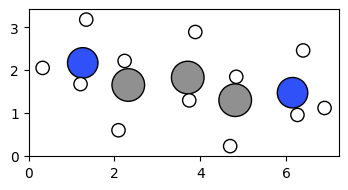

Nitrogen atom at index 2 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 2 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...


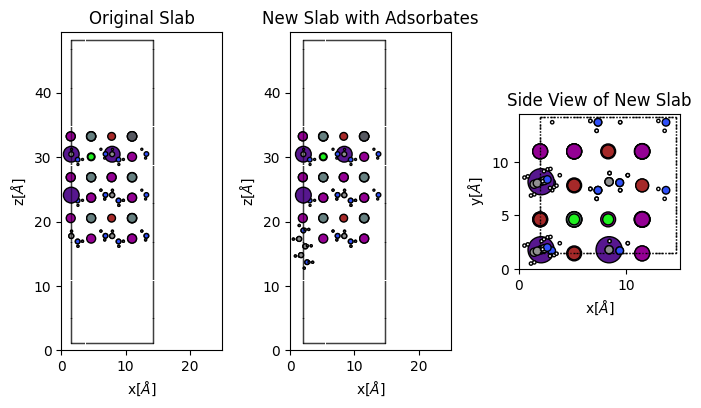

Saved new slab structure to Hong_passivation_mixed/PDAI.png_slab.vasp


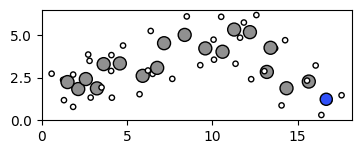

Nitrogen atom at index 18 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 18
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 18 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 18
Molecule penetrates the slab. Adjusting...


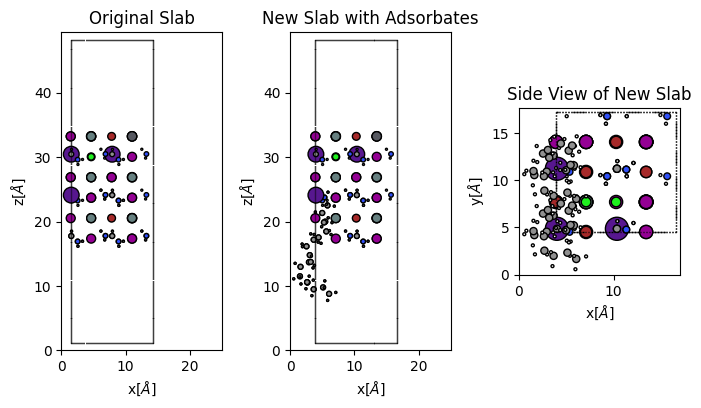

Saved new slab structure to Hong_passivation_mixed/OLAI.png_slab.vasp


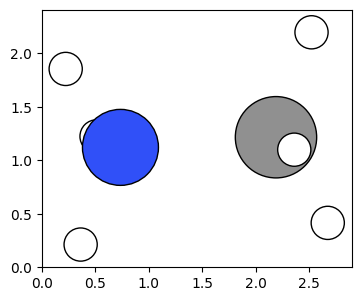

Nitrogen atom at index 1 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 1
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 1 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 1
Molecule penetrates the slab. Adjusting...


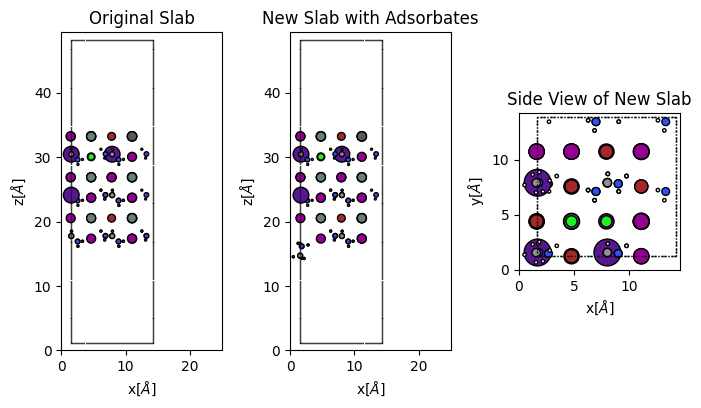

Saved new slab structure to Hong_passivation_mixed/MS.png_slab.vasp


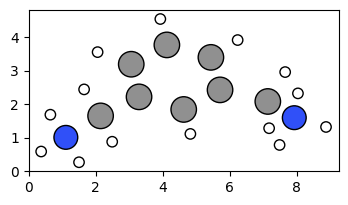

Nitrogen atom at index 7 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 7
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 7 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 7
Molecule penetrates the slab. Adjusting...


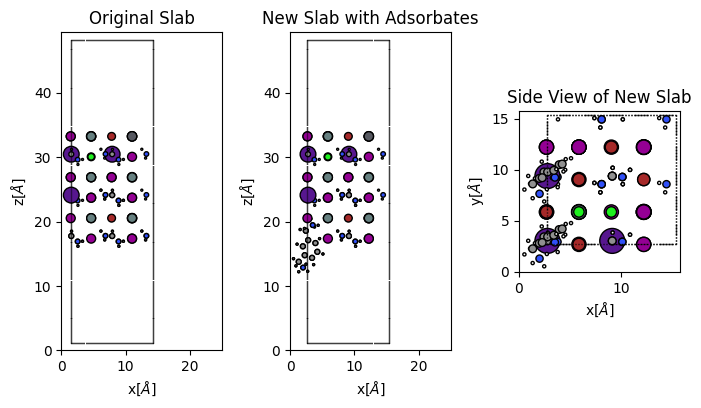

Saved new slab structure to Hong_passivation_mixed/m-PBAI2.png_slab.vasp


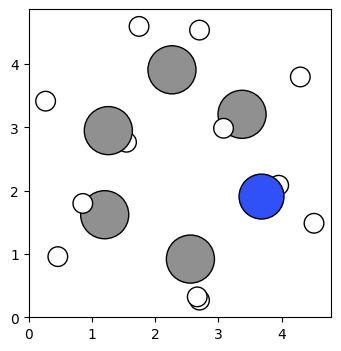

Nitrogen atom at index 3 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 3
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 3 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 3
Molecule penetrates the slab. Adjusting...


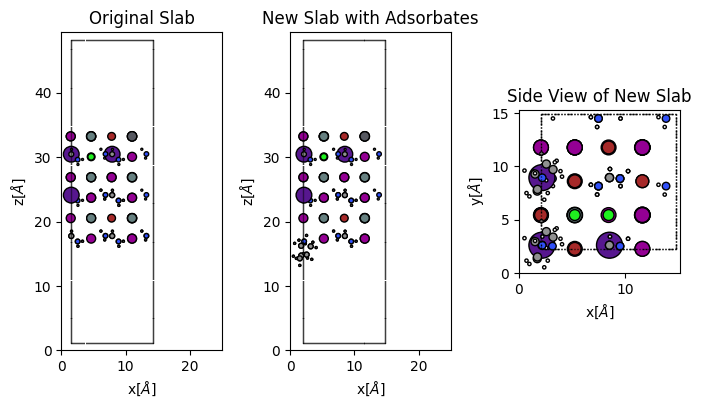

Saved new slab structure to Hong_passivation_mixed/PpI.png_slab.vasp


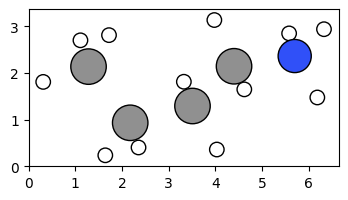

Nitrogen atom at index 4 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 4
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 4 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 4
Molecule penetrates the slab. Adjusting...


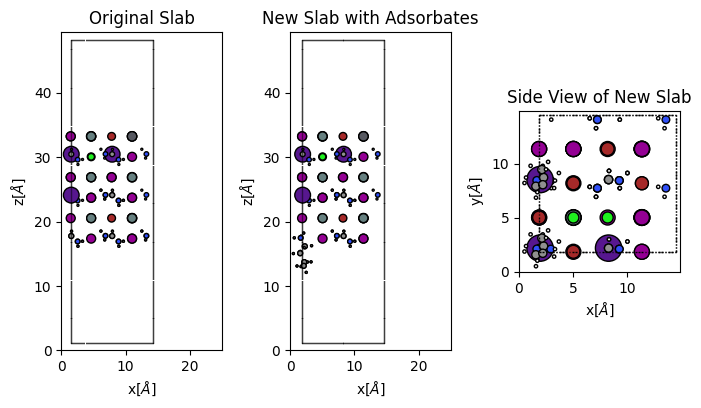

Saved new slab structure to Hong_passivation_mixed/BAI.png_slab.vasp


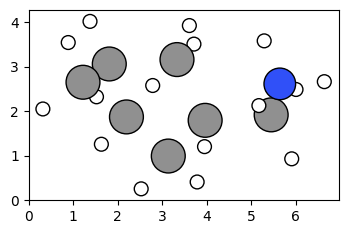

Nitrogen atom at index 7 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 7
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 7 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 7
Molecule penetrates the slab. Adjusting...


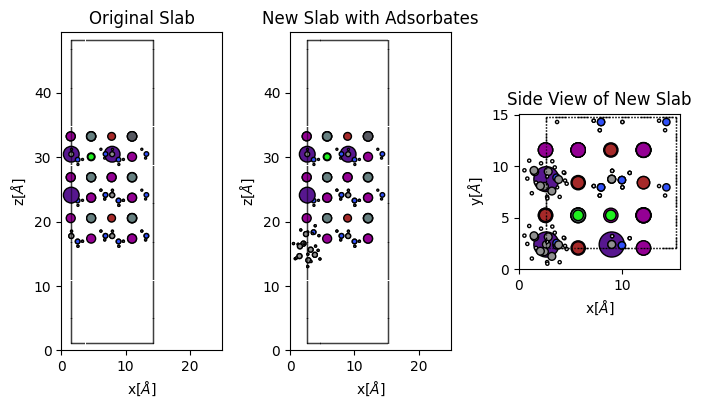

Saved new slab structure to Hong_passivation_mixed/CHMAI.png_slab.vasp


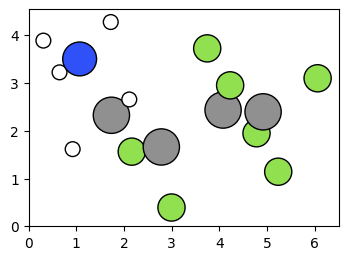

Nitrogen atom at index 11 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 11
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 11 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 11
Molecule penetrates the slab. Adjusting...


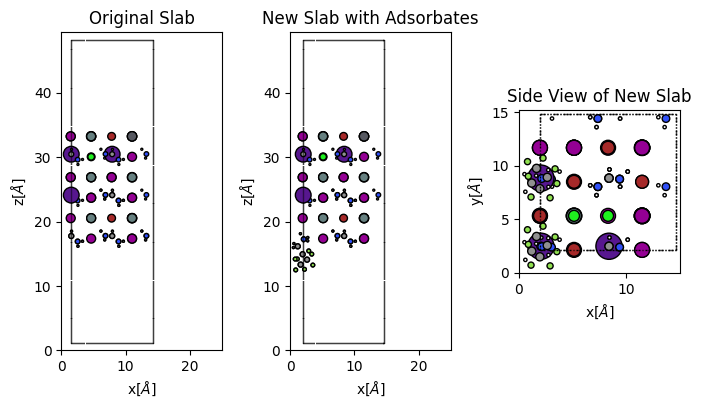

Saved new slab structure to Hong_passivation_mixed/HBAI.png_slab.vasp


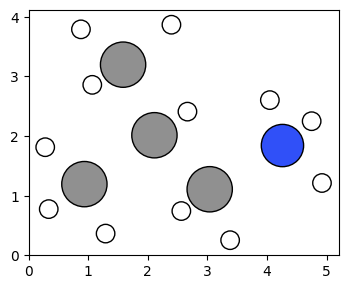

Nitrogen atom at index 4 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 4
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 4 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 4
Molecule penetrates the slab. Adjusting...


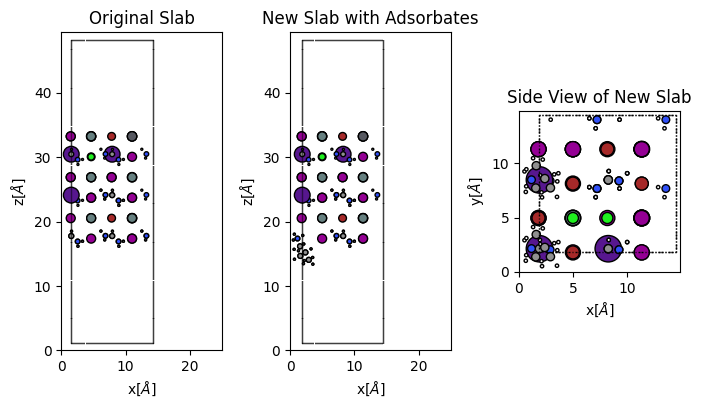

Saved new slab structure to Hong_passivation_mixed/iso-BAI.png_slab.vasp


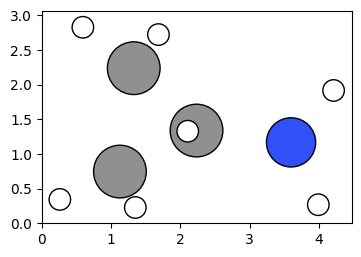

Nitrogen atom at index 3 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 3
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 3 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 3
Molecule penetrates the slab. Adjusting...


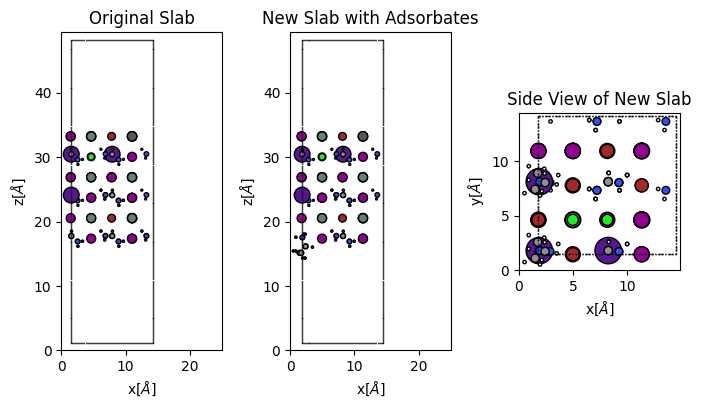

Saved new slab structure to Hong_passivation_mixed/CAI.png_slab.vasp


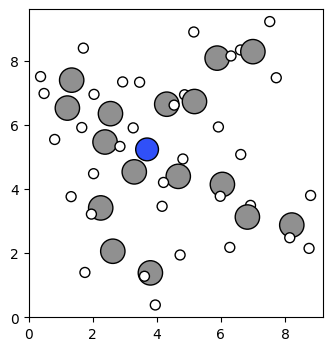

Nitrogen atom at index 4 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 4
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 4 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 4
Molecule penetrates the slab. Adjusting...


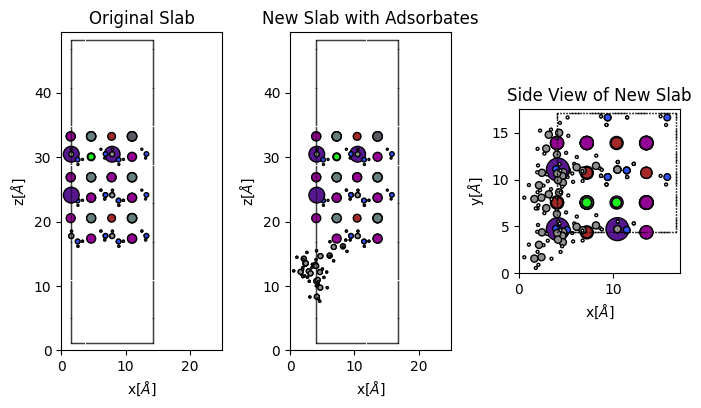

Saved new slab structure to Hong_passivation_mixed/TBAI.png_slab.vasp


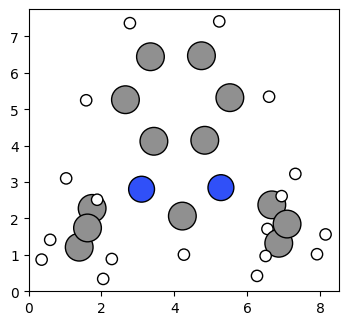

Nitrogen atom at index 3 has the highest number of bonded neighbors: 3
Index of nitrogen with most hydrogens: 3
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 3 has the highest number of bonded neighbors: 3
Index of nitrogen with most hydrogens: 3
Molecule penetrates the slab. Adjusting...


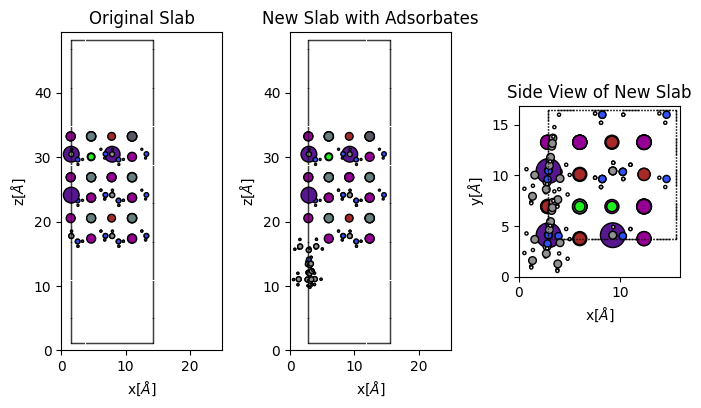

Saved new slab structure to Hong_passivation_mixed/iprl.png_slab.vasp


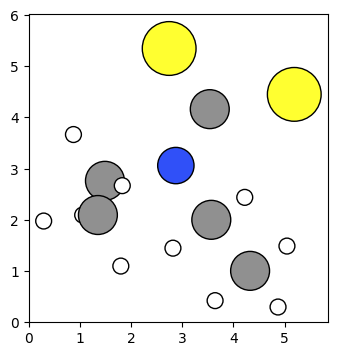

Nitrogen atom at index 2 has the highest number of bonded neighbors: 3
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 2 has the highest number of bonded neighbors: 3
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...


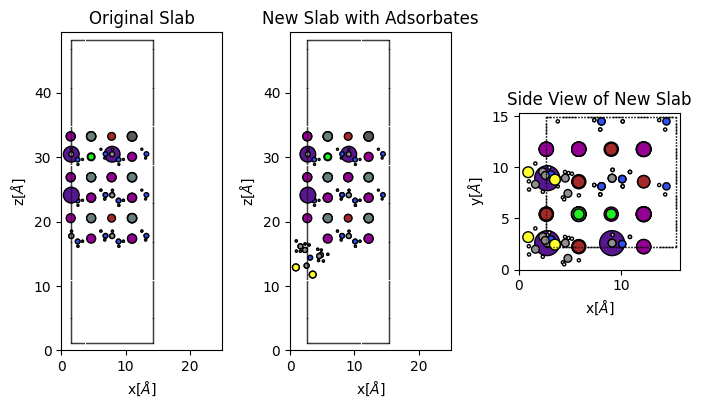

Saved new slab structure to Hong_passivation_mixed/DEDTC.png_slab.vasp


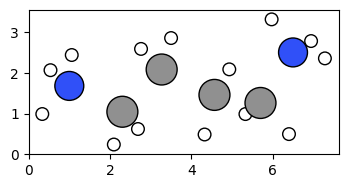

Nitrogen atom at index 3 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 3
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 3 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 3
Molecule penetrates the slab. Adjusting...


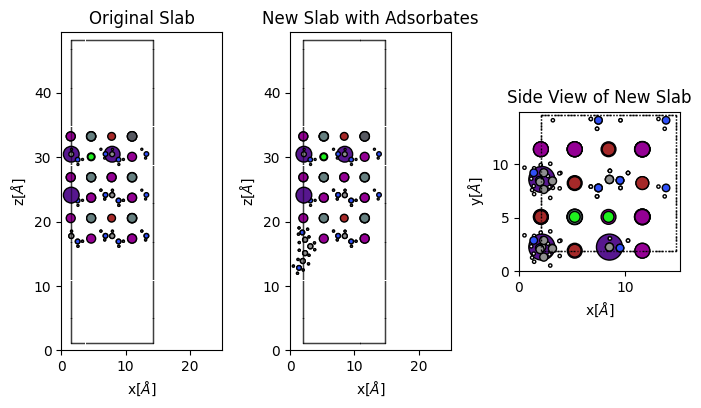

Saved new slab structure to Hong_passivation_mixed/BDAI.png_slab.vasp


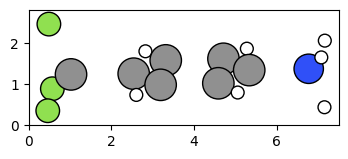

Nitrogen atom at index 6 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 6
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 6 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 6
Molecule penetrates the slab. Adjusting...


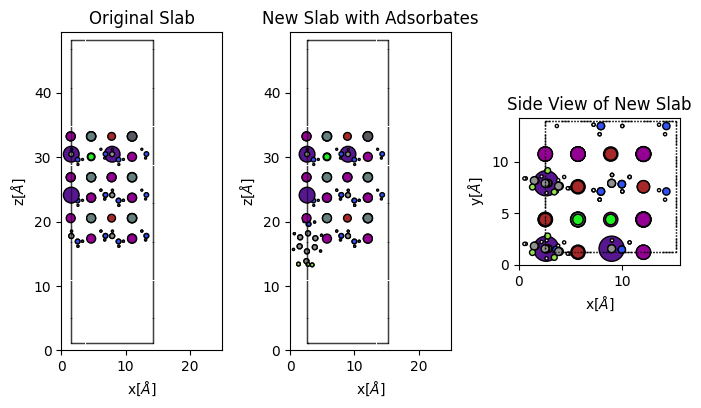

Saved new slab structure to Hong_passivation_mixed/CF3-PA.png_slab.vasp


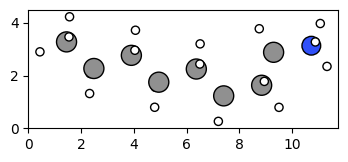

Nitrogen atom at index 8 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 8
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 8 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 8
Molecule penetrates the slab. Adjusting...


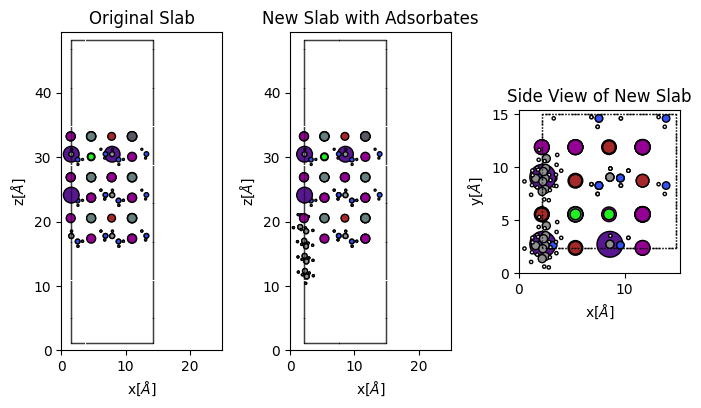

Saved new slab structure to Hong_passivation_mixed/OATsO.png_slab.vasp


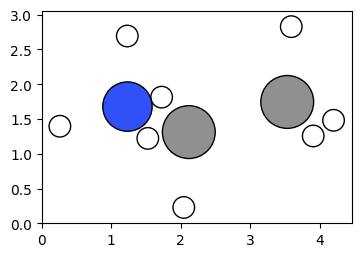

Nitrogen atom at index 2 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 2 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...


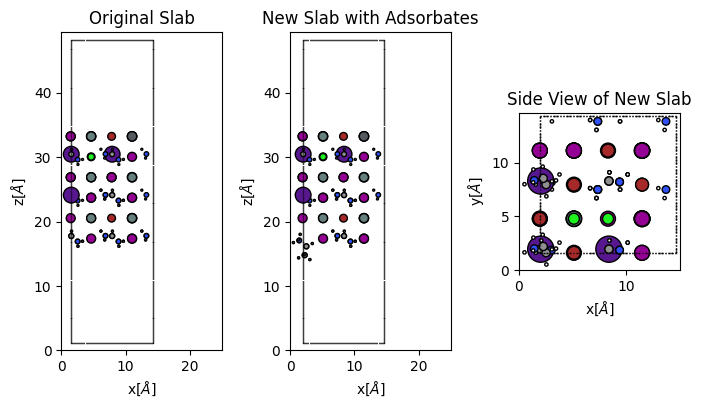

Saved new slab structure to Hong_passivation_mixed/EAI.png_slab.vasp


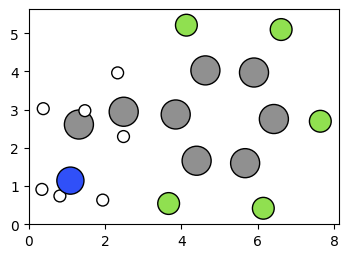

Nitrogen atom at index 2 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 2 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...


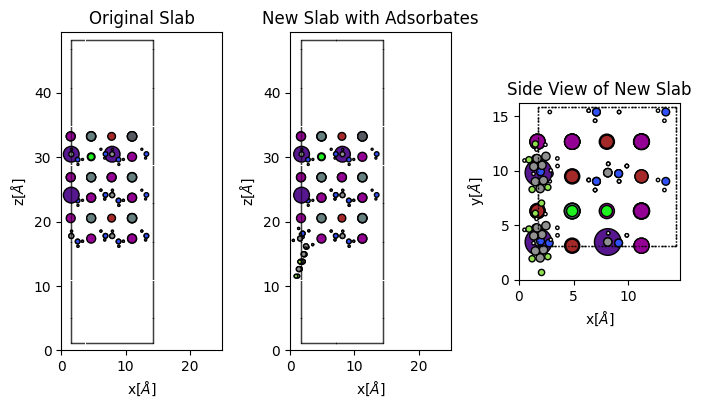

Saved new slab structure to Hong_passivation_mixed/FEAI.png_slab.vasp


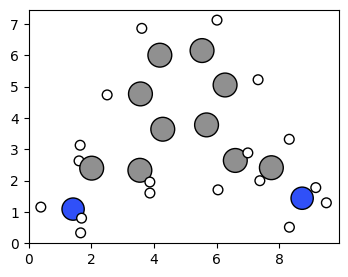

Nitrogen atom at index 8 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 8
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 8 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 8
Molecule penetrates the slab. Adjusting...


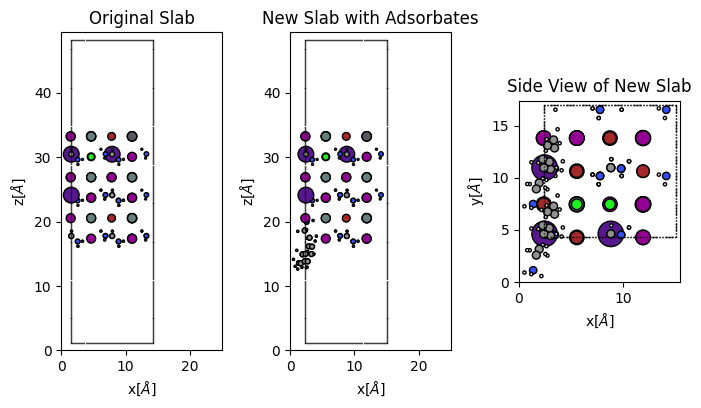

Saved new slab structure to Hong_passivation_mixed/o-PDEAI2.png_slab.vasp


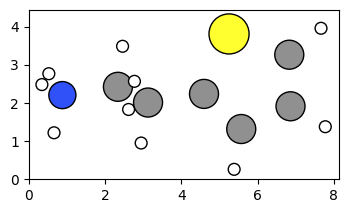

Nitrogen atom at index 7 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 7
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 7 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 7
Molecule penetrates the slab. Adjusting...


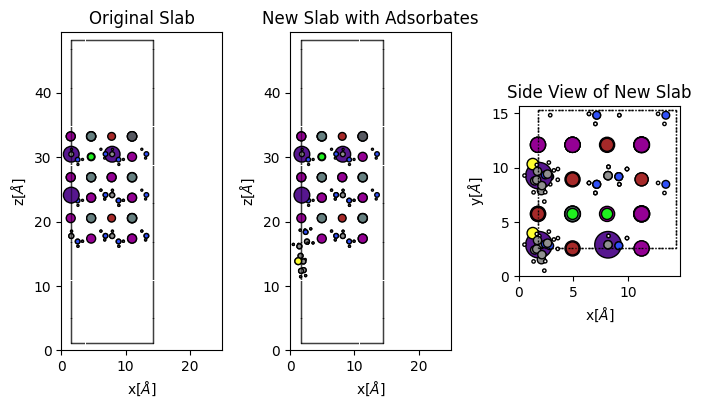

Saved new slab structure to Hong_passivation_mixed/TEASCN.png_slab.vasp


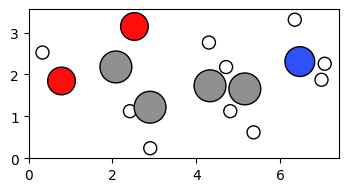

Nitrogen atom at index 6 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 6
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 6 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 6
Molecule penetrates the slab. Adjusting...


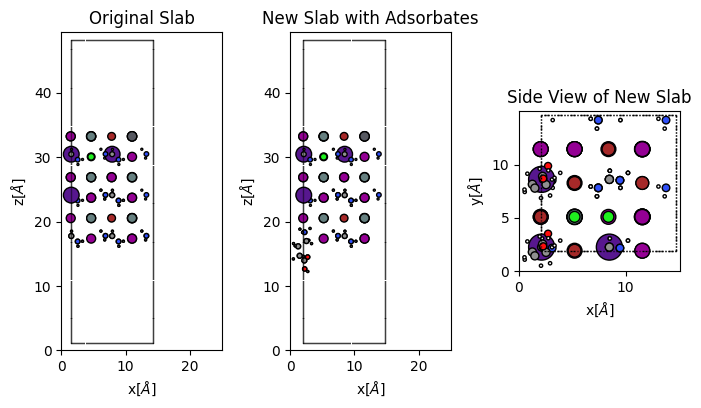

Saved new slab structure to Hong_passivation_mixed/AVAI.png_slab.vasp


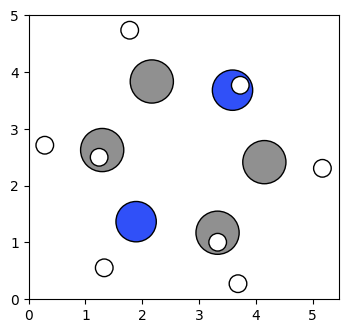

Nitrogen atom at index 2 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 2 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...


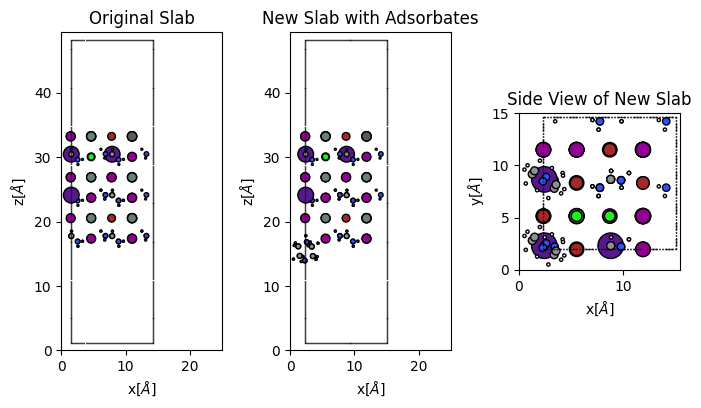

Saved new slab structure to Hong_passivation_mixed/PI.png_slab.vasp


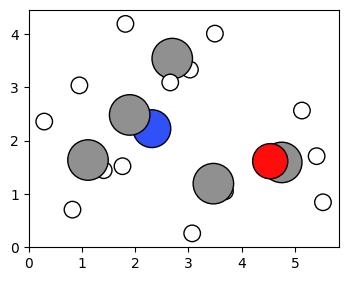

Nitrogen atom at index 1 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 1
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 1 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 1
Molecule penetrates the slab. Adjusting...


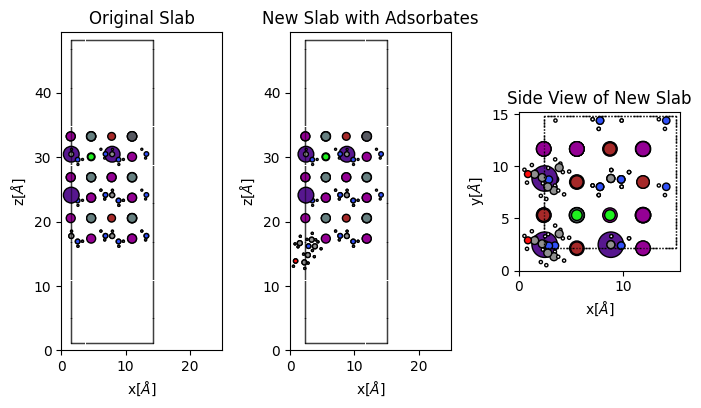

Saved new slab structure to Hong_passivation_mixed/Choline_chloride.png_slab.vasp


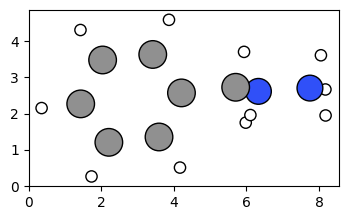

Nitrogen atom at index 8 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 8
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 8 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 8
Molecule penetrates the slab. Adjusting...


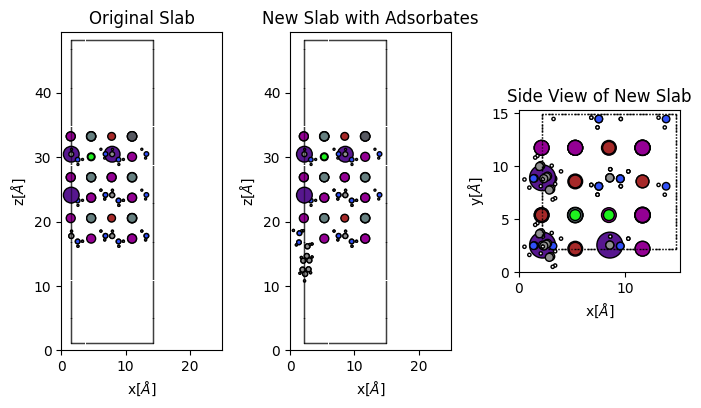

Saved new slab structure to Hong_passivation_mixed/BHC.png_slab.vasp


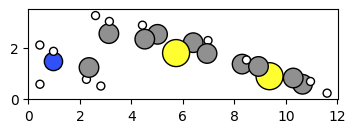

Nitrogen atom at index 11 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 11
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 11 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 11
Molecule penetrates the slab. Adjusting...


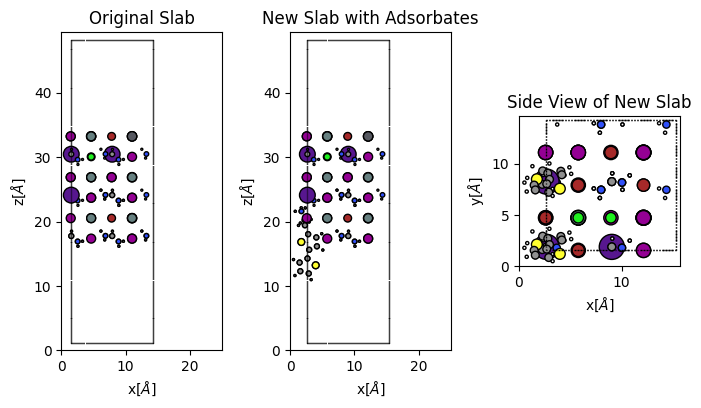

Saved new slab structure to Hong_passivation_mixed/2TEAI.png_slab.vasp


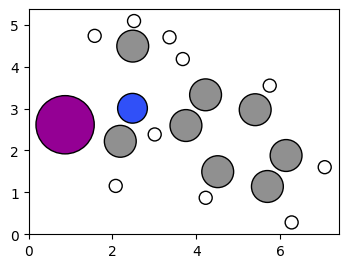

Nitrogen atom at index 1 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 1
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 1 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 1
Molecule penetrates the slab. Adjusting...


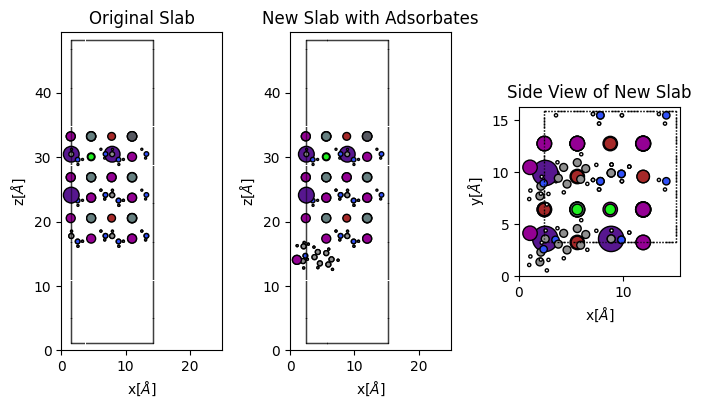

Saved new slab structure to Hong_passivation_mixed/PTAI.png_slab.vasp


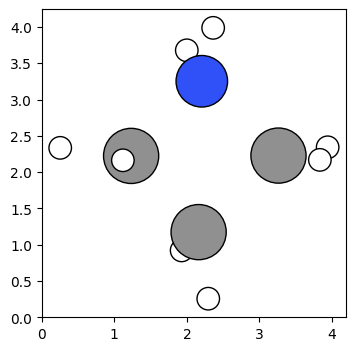

Nitrogen atom at index 2 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 2 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...


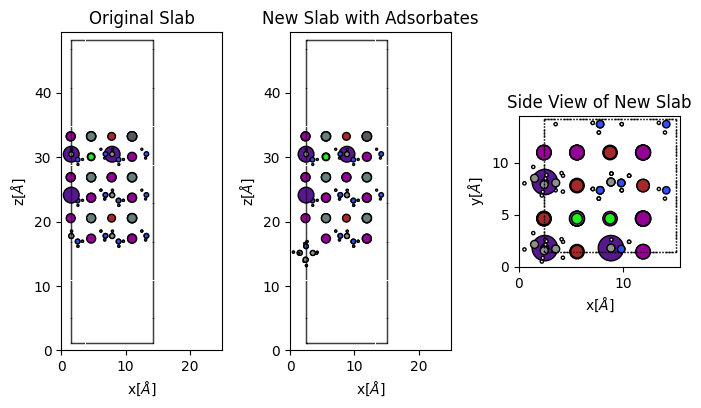

Saved new slab structure to Hong_passivation_mixed/AzI.png_slab.vasp


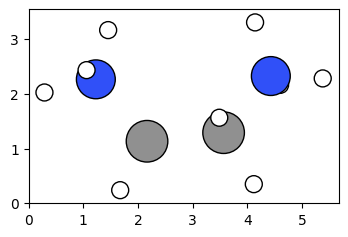

Nitrogen atom at index 2 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 2 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...


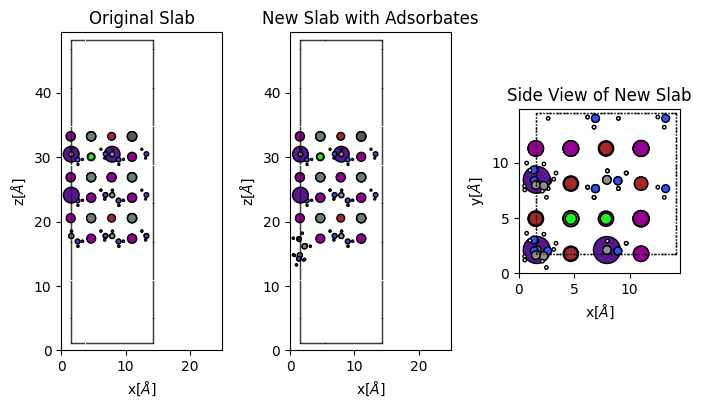

Saved new slab structure to Hong_passivation_mixed/EDAI.png_slab.vasp


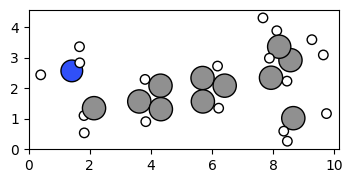

Nitrogen atom at index 11 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 11
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 11 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 11
Molecule penetrates the slab. Adjusting...


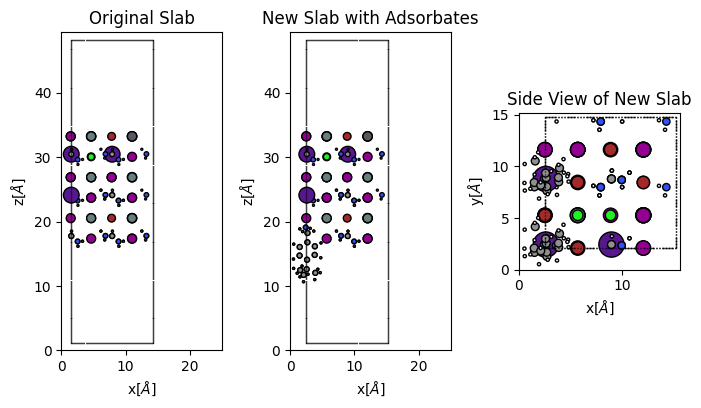

Saved new slab structure to Hong_passivation_mixed/tBBAI.png_slab.vasp


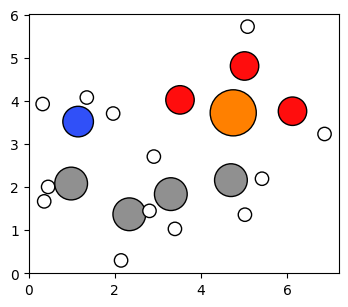

Nitrogen atom at index 8 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 8
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 8 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 8
Molecule penetrates the slab. Adjusting...


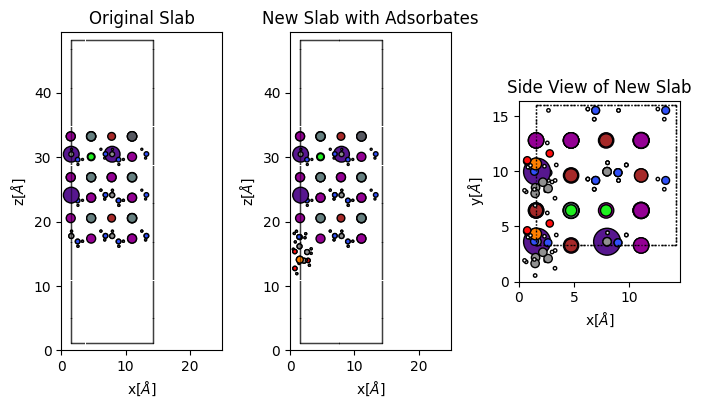

Saved new slab structure to Hong_passivation_mixed/ABPC.png_slab.vasp


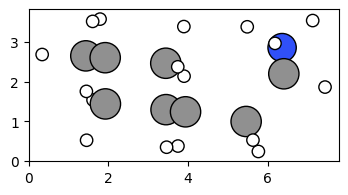

Nitrogen atom at index 8 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 8
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 8 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 8
Molecule penetrates the slab. Adjusting...


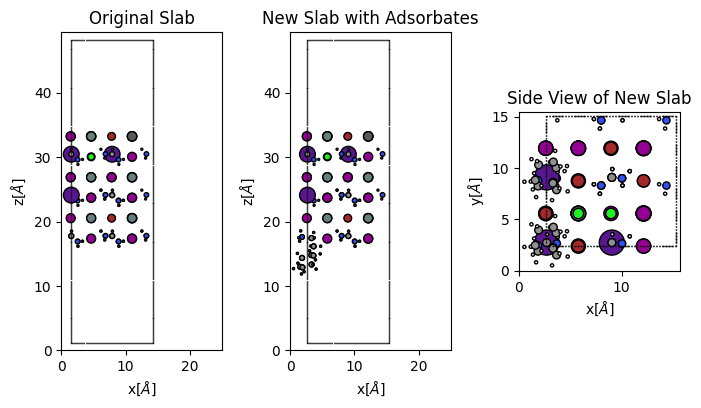

Saved new slab structure to Hong_passivation_mixed/CEAI.png_slab.vasp


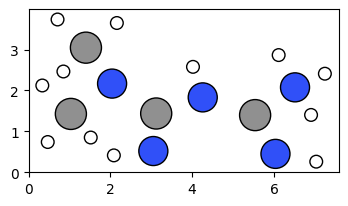

Nitrogen atom at index 8 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 8
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 8 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 8
Molecule penetrates the slab. Adjusting...


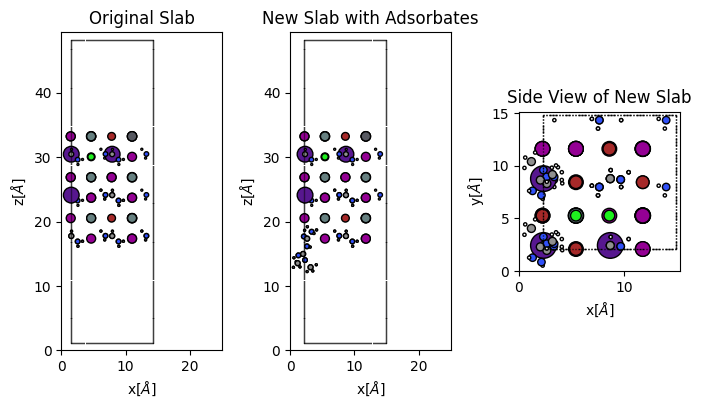

Saved new slab structure to Hong_passivation_mixed/DIAI.png_slab.vasp


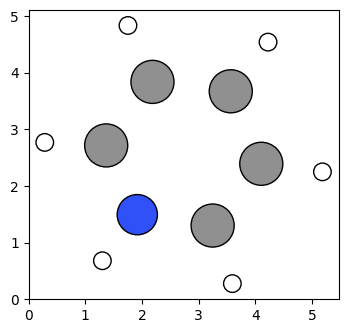

Nitrogen atom at index 3 has the highest number of bonded neighbors: 3
Index of nitrogen with most hydrogens: 3
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 3 has the highest number of bonded neighbors: 3
Index of nitrogen with most hydrogens: 3
Molecule penetrates the slab. Adjusting...


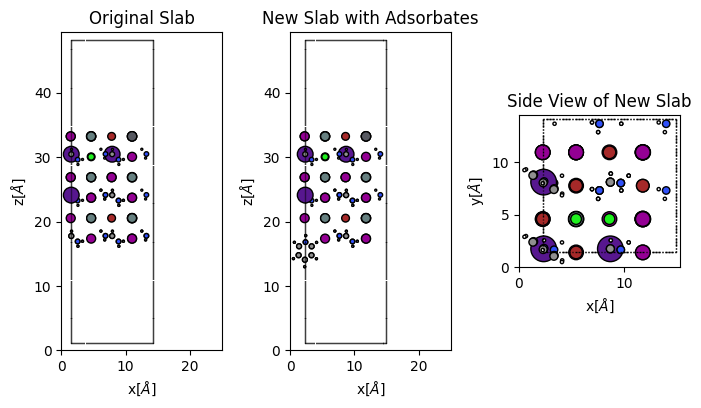

Saved new slab structure to Hong_passivation_mixed/PyI.png_slab.vasp


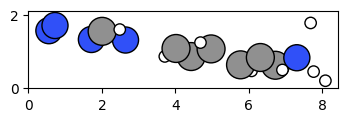

Nitrogen atom at index 6 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 6
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 6 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 6
Molecule penetrates the slab. Adjusting...


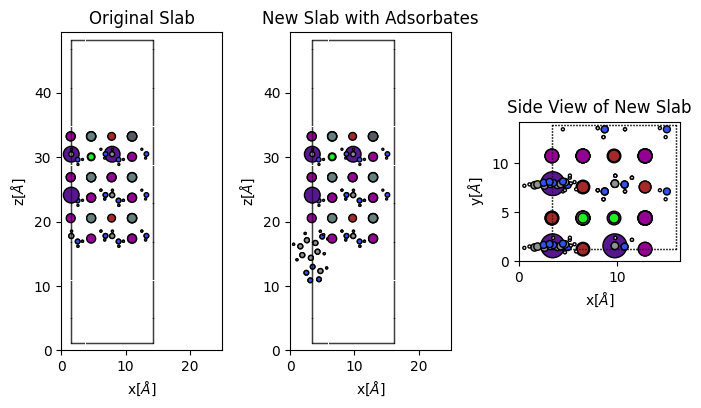

Saved new slab structure to Hong_passivation_mixed/SN.png_slab.vasp


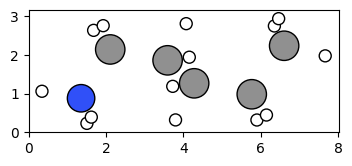

Nitrogen atom at index 5 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 5
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 5 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 5
Molecule penetrates the slab. Adjusting...


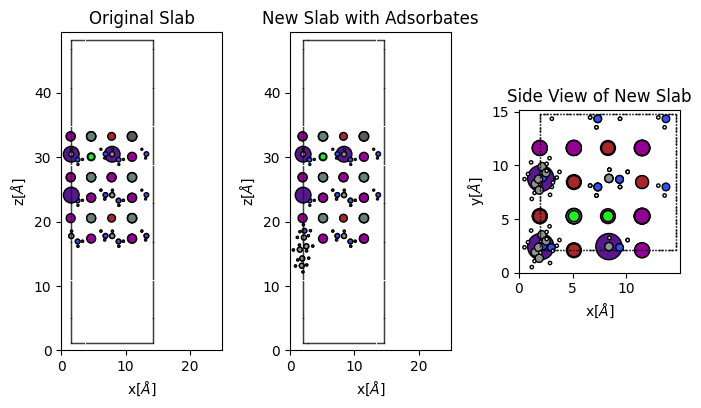

Saved new slab structure to Hong_passivation_mixed/PenAAC.png_slab.vasp


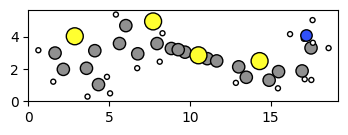

Nitrogen atom at index 19 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 19
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 19 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 19
Molecule penetrates the slab. Adjusting...


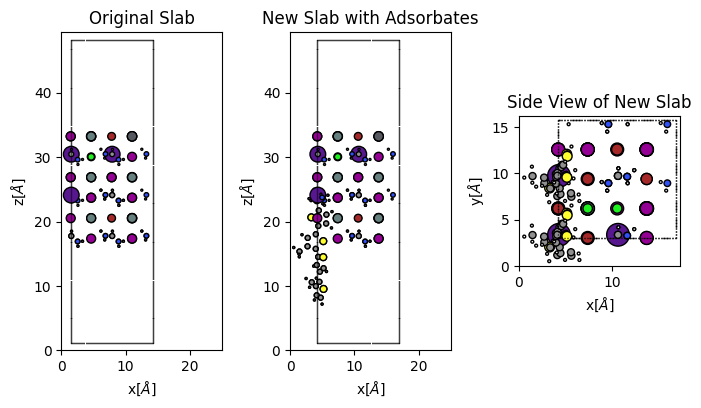

Saved new slab structure to Hong_passivation_mixed/4Tm.png_slab.vasp


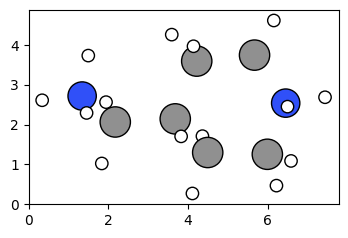

Nitrogen atom at index 2 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 2 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...


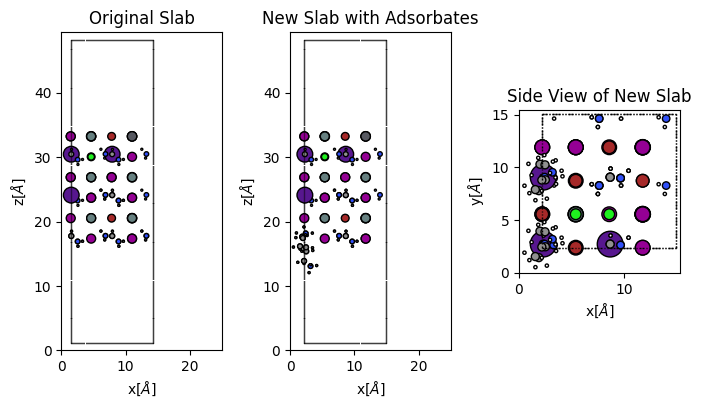

Saved new slab structure to Hong_passivation_mixed/4AMP.png_slab.vasp


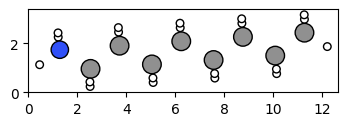

Nitrogen atom at index 8 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 8
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 8 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 8
Molecule penetrates the slab. Adjusting...


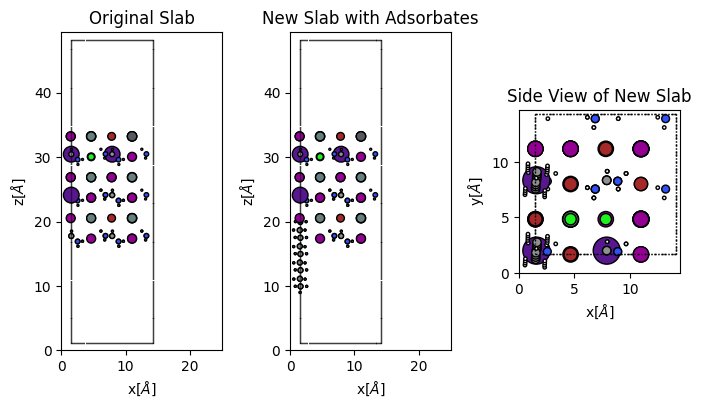

Saved new slab structure to Hong_passivation_mixed/OAI.png_slab.vasp


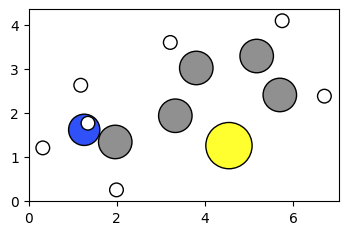

Nitrogen atom at index 6 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 6
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 6 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 6
Molecule penetrates the slab. Adjusting...


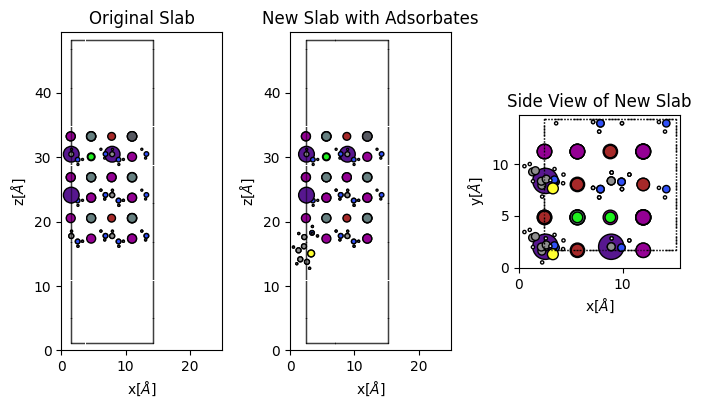

Saved new slab structure to Hong_passivation_mixed/2-TMABr.png_slab.vasp


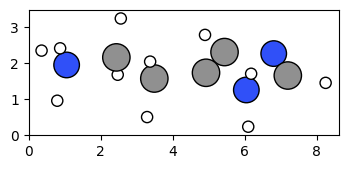

Nitrogen atom at index 2 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 2 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...


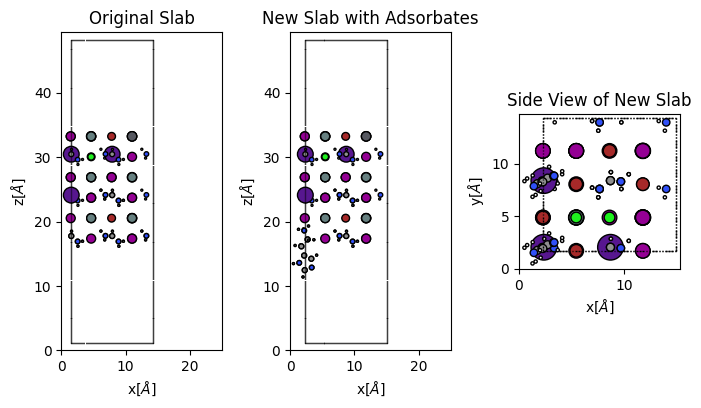

Saved new slab structure to Hong_passivation_mixed/HADI.png_slab.vasp


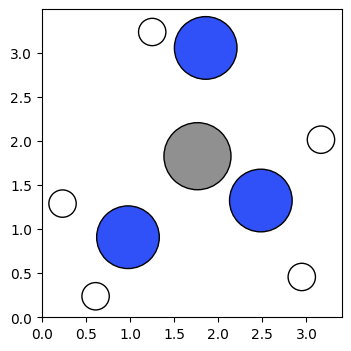

Nitrogen atom at index 2 has the highest number of bonded neighbors: 3
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 2 has the highest number of bonded neighbors: 3
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...


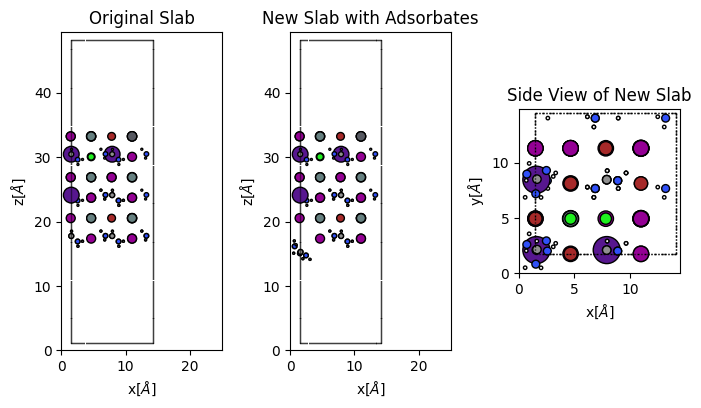

Saved new slab structure to Hong_passivation_mixed/GABr.png_slab.vasp


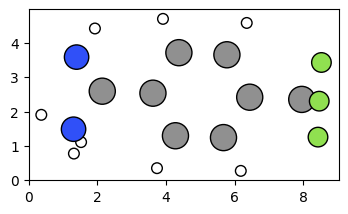

Nitrogen atom at index 12 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 12
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 12 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 12
Molecule penetrates the slab. Adjusting...


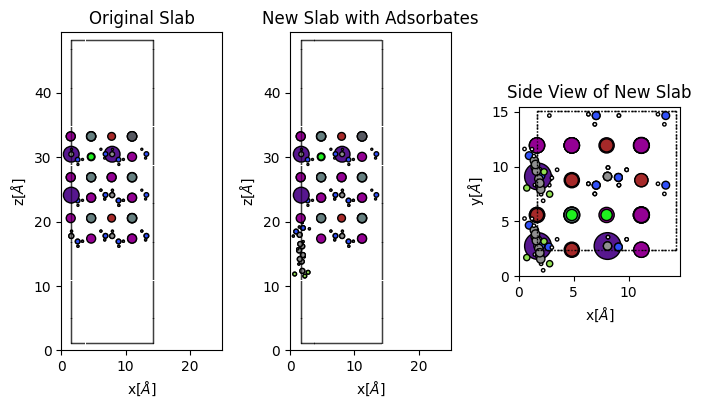

Saved new slab structure to Hong_passivation_mixed/THPhFACl.png_slab.vasp


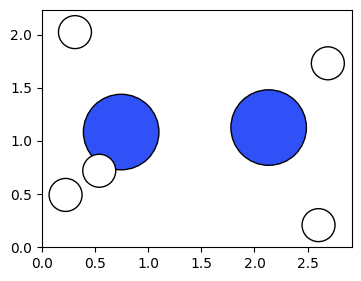

Nitrogen atom at index 0 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 0
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 0 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 0
Molecule penetrates the slab. Adjusting...


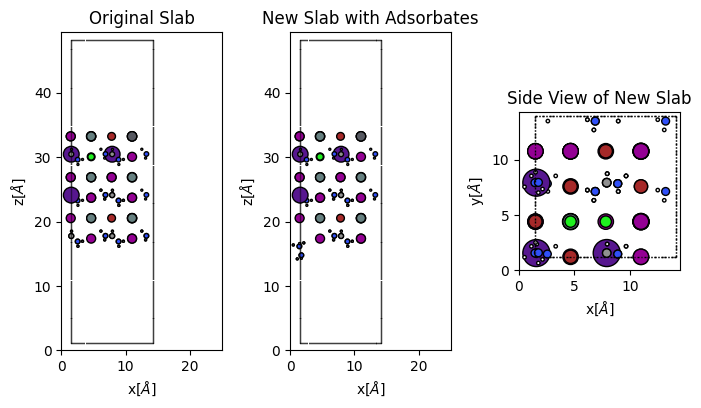

Saved new slab structure to Hong_passivation_mixed/HAI.png_slab.vasp


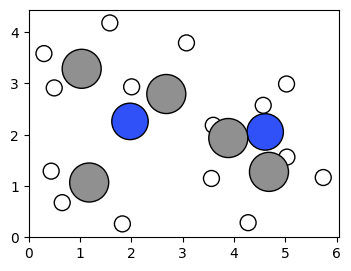

Nitrogen atom at index 6 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 6
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 6 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 6
Molecule penetrates the slab. Adjusting...


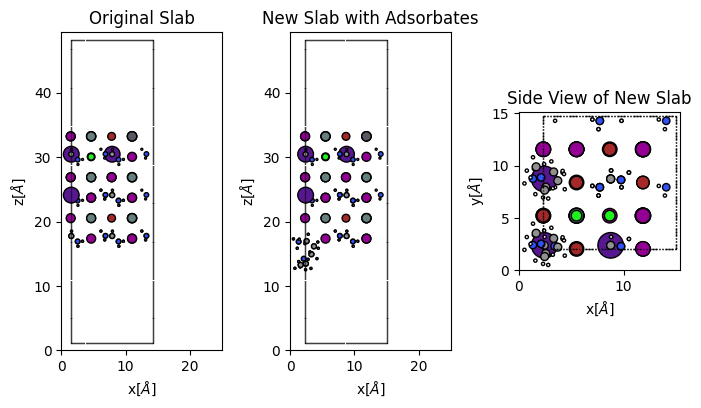

Saved new slab structure to Hong_passivation_mixed/DMePDAI.png_slab.vasp


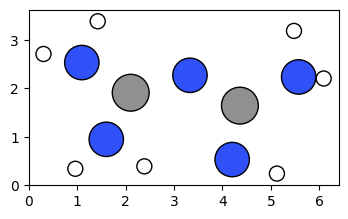

Nitrogen atom at index 2 has the highest number of bonded neighbors: 3
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 2 has the highest number of bonded neighbors: 3
Index of nitrogen with most hydrogens: 2
Molecule penetrates the slab. Adjusting...


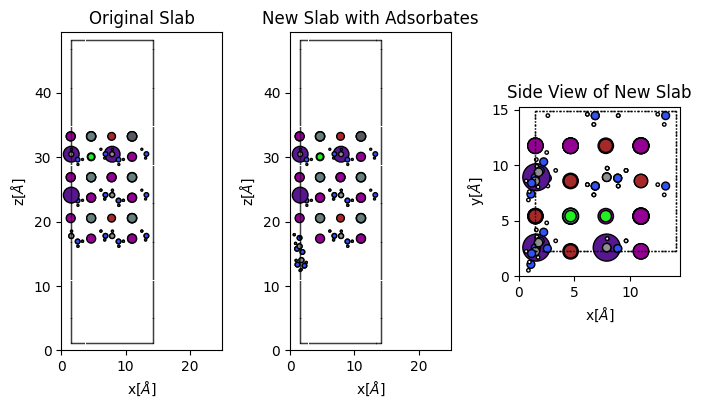

Saved new slab structure to Hong_passivation_mixed/BGCI.png_slab.vasp


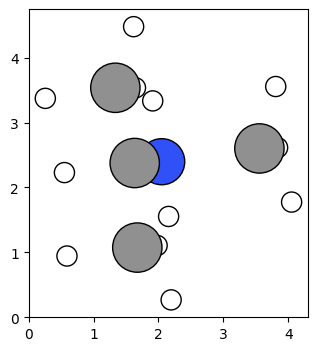

Nitrogen atom at index 1 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 1
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 1 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 1
Molecule penetrates the slab. Adjusting...


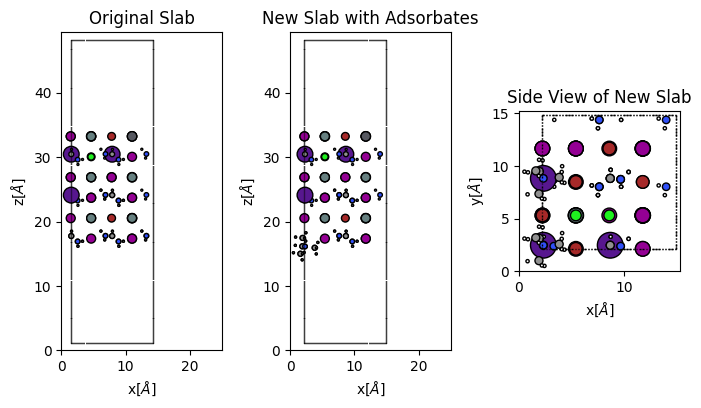

Saved new slab structure to Hong_passivation_mixed/CDCA-TMN.png_slab.vasp


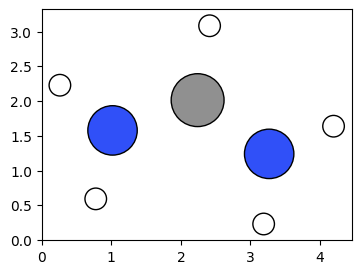

Nitrogen atom at index 1 has the highest number of bonded neighbors: 3
Index of nitrogen with most hydrogens: 1
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 1 has the highest number of bonded neighbors: 3
Index of nitrogen with most hydrogens: 1
Molecule penetrates the slab. Adjusting...


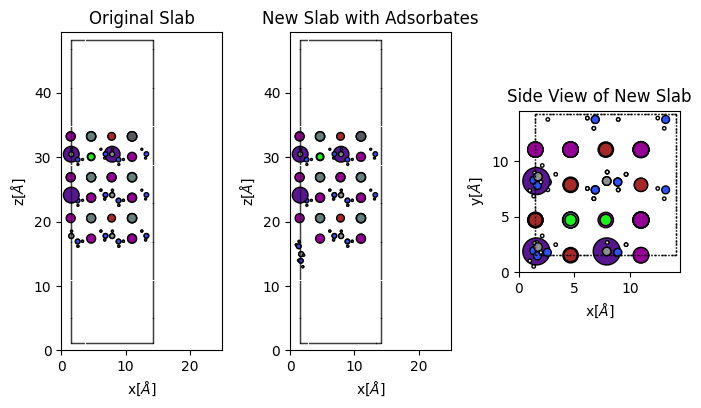

Saved new slab structure to Hong_passivation_mixed/FAFa.png_slab.vasp


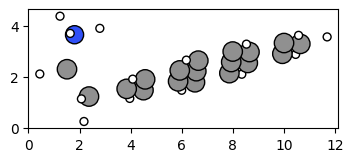

Nitrogen atom at index 10 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 10
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 10 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 10
Molecule penetrates the slab. Adjusting...


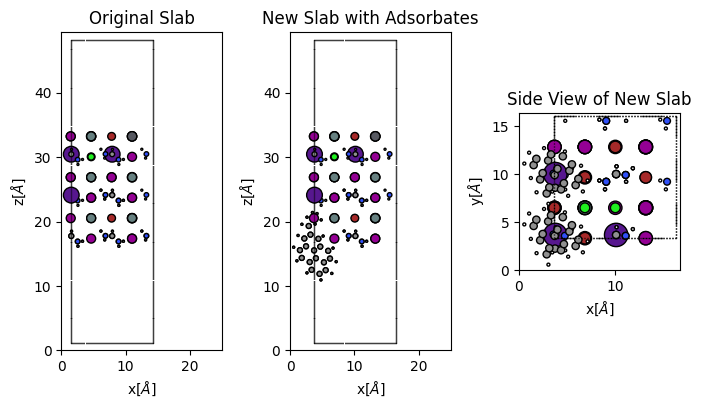

Saved new slab structure to Hong_passivation_mixed/PREA.png_slab.vasp


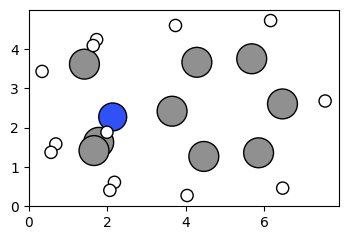

Nitrogen atom at index 1 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 1
Molecule penetrates the slab. Adjusting...
Nitrogen atom at index 1 has the highest number of bonded neighbors: 4
Index of nitrogen with most hydrogens: 1
Molecule penetrates the slab. Adjusting...


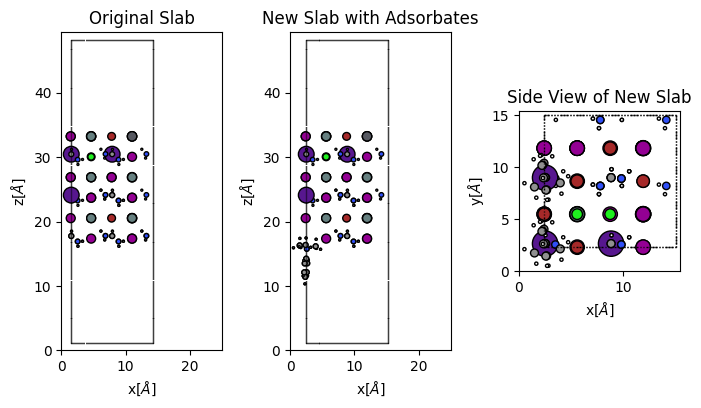

Saved new slab structure to Hong_passivation_mixed/TPABr3.png_slab.vasp


In [15]:
import os
from DECIMER import predict_SMILES
from ase.data.pubchem import pubchem_atoms_search, pubchem_atoms_conformer_search
from rdkit import Chem
from rdkit.Chem import AllChem
from ase.io import read, write  # Make sure to import these functions
import matplotlib.pyplot as plt
from ase.visualize import view


def SmilesToMol(smiles):
    """
    Converts a SMILES string to an RDKit molecule, adds hydrogens,
    embeds the molecule in 3D space, and optimizes it.
    
    Args:
        smiles (str): SMILES representation of the molecule.
    
    Returns:
        mol: An RDKit Mol object if successful, otherwise None.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Failed to create molecule from SMILES: {smiles}")
        return None
    
    # Add hydrogens to the molecule
    hmol = Chem.AddHs(mol)
    
    # Embed molecule in 3D space
    AllChem.EmbedMolecule(hmol)
    
    # Optimize the 3D structure
    AllChem.MMFFOptimizeMolecule(hmol)
    
    return hmol

def contains_nitrogen(mol):
    """
    Checks if the given molecule contains a nitrogen atom.
    
    Args:
        mol: An RDKit Mol object.
    
    Returns:
        bool: True if nitrogen is present, False otherwise.
    """
    return any(atom.GetSymbol() == 'N' for atom in mol.GetAtoms())

def process_images_in_folder(folder_path):
    # Iterate through all files in the specified folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):  # Change this if you need other formats
            image_path = os.path.join(folder_path, filename)

            # Predict SMILES from the image
            SMILES = predict_SMILES(image_path)
            split_smiles = SMILES.split(sep='.')
            
            # Find the first fragment containing nitrogen
            organic_mol = None
            for smiles_fragment in split_smiles:
                mol = SmilesToMol(smiles_fragment)
                if mol and contains_nitrogen(mol):
                    organic_mol = mol
                    break

            if organic_mol is None:
                raise ValueError("No organic fragment containing nitrogen was found.")

            # Save the organic fragment containing nitrogen to a .mol file
            Chem.MolToMolFile(organic_mol, f'{filename}_test.mol')

            # Read the .mol file with ASE
            molecule = read(f'{filename}_test.mol')

            # Plot the molecule
            fig, axes = plt.subplots(1, 1, figsize=(4, 4))
            plot_atoms(molecule, axes, radii=0.5, rotation=('0x,0y,0z'))
            plt.show()

            # Perform adsorption automation (you may want to customize this)
            # Define the folder where you want to save the output
            output_folder = 'Hong_passivation_mixed'

            # Create the folder if it does not exist
            os.makedirs(output_folder, exist_ok=True)

            # Define the output file path
            output_file = os.path.join(output_folder, f'{filename}_slab.vasp')
            
            automate_adsorption('surface_001.vasp', molecule, num_replace_FA=2, output_file=output_file)

            # Load the slab for visualization
            slab = read(output_file)
            view(slab, viewer='ngl')

# Example usage
folder_path = "./Figure_5_Hong/"
process_images_in_folder(folder_path)

In [ ]:
!mkdir Hong_passivation_mixed

In [ ]:
import os
from DECIMER import predict_SMILES
from ase.data.pubchem import pubchem_atoms_search, pubchem_atoms_conformer_search
from rdkit import Chem
from rdkit.Chem import AllChem
from ase.io import read, write  # Make sure to import these functions
import matplotlib.pyplot as plt
from ase.visualize import view
from ase.geometry import distance


def SmilesToMol(smiles):
    """
    Converts a SMILES string to an RDKit molecule, adds hydrogens,
    embeds the molecule in 3D space, and optimizes it.
    
    Args:
        smiles (str): SMILES representation of the molecule.
    
    Returns:
        mol: An RDKit Mol object if successful, otherwise None.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Failed to create molecule from SMILES: {smiles}")
        return None
    
    # Add hydrogens to the molecule
    hmol = Chem.AddHs(mol)
    
    # Embed molecule in 3D space
    AllChem.EmbedMolecule(hmol)
    
    # Optimize the 3D structure
    AllChem.MMFFOptimizeMolecule(hmol)
    
    return hmol

def contains_nitrogen(mol):
    """
    Checks if the given molecule contains a nitrogen atom.
    
    Args:
        mol: An RDKit Mol object.
    
    Returns:
        bool: True if nitrogen is present, False otherwise.
    """
    return any(atom.GetSymbol() == 'N' for atom in mol.GetAtoms())

def process_images_in_folder(image_path):
        image_path = image_path
        filename = 'PDAI'
        # Predict SMILES from the image
        SMILES = predict_SMILES(image_path)

        smiles_fragment = 'C(C[NH3+])C[NH3+]'
        mol = SmilesToMol(smiles_fragment)

        # Save the organic fragment containing nitrogen to a .mol file
        Chem.MolToMolFile(mol, f'{filename}_test.mol')

        # Read the .mol file with ASE
        molecule = read(f'{filename}_test.mol')

        # Plot the molecule
        fig, axes = plt.subplots(1, 1, figsize=(4, 4))
        plot_atoms(molecule, axes, radii=0.5, rotation=('0x,0y,0z'))
        plt.show()

        # Define the folder where you want to save the output
        output_folder = 'Hong_passivation_mixed'

        # Create the folder if it does not exist
        os.makedirs(output_folder, exist_ok=True)

        # Define the output file path
        output_file = os.path.join(output_folder, f'{filename}_slab.vasp')

        automate_adsorption('surface_001.vasp', molecule, num_replace_FA=2, output_file=output_file)

        # Load the slab for visualization
        slab = read(output_file)
        view(slab, viewer='ngl')

# Example usage
image_path = "./Figure_5_Hong/PDAI.png"
process_images_in_folder(image_path)

In [ ]:
molecule

In [ ]:
from ase import Atoms
from ase.io import read, write
import numpy as np
import matplotlib.pyplot as plt


# Atomic radii (in Angstroms)
atomic_radii = {
    'N': 0.70,  # Nitrogen radius (approximate)
    'I': 1.33,  # Iodine radius (approximate)
}

def find_nh3_groups(atoms):
    """
    Identify NH3 groups in the molecule.
    Returns a list of indices of nitrogen atoms belonging to NH3 groups.
    """
    nh3_indices = []
    for atom in atoms:
        if atom.symbol == 'N':  # Look for Nitrogen
            # Find bonded hydrogen atoms
            bonded_h = [i for i in range(len(atoms)) if atoms[i].symbol == 'H' and np.linalg.norm(atoms[i].position - atom.position) < 1.2]
            if len(bonded_h) == 3:  # NH3 group has exactly 3 hydrogens
                nh3_indices.append(atom.index)
    return nh3_indices

def find_farthest_nh3(atoms, nh3_indices):
    """
    Find the NH3 group farthest from the slab's surface.
    Assumes the slab is oriented along the z-axis and uses the z-coordinate of the nitrogen atoms.
    """
    farthest_nh3_index = None
    max_distance = -np.inf
    for nh3_index in nh3_indices:
        nitrogen_pos = atoms[nh3_index].position
        z_distance = nitrogen_pos[2]  # Assuming slab is oriented along z-axis
        if z_distance > max_distance:
            max_distance = z_distance
            farthest_nh3_index = nh3_index
    return farthest_nh3_index

def add_iodine_near_nh3(atoms, nh3_index, bond_length=3.5):
    """
    Add an iodine atom near the given NH3 group, to the side of the nitrogen, ensuring it does not overlap with hydrogens.
    :param atoms: ASE Atoms object
    :param nh3_index: Index of the nitrogen atom in the NH3 group
    :param bond_length: Desired bond length between Iodine and Nitrogen
    """
    nitrogen_pos = atoms[nh3_index].position
    
    # Calculate the distance based on atomic radii
    nitrogen_radius = atomic_radii['N']
    iodine_radius = atomic_radii['I']
    effective_bond_length = bond_length - (nitrogen_radius + iodine_radius)  # Adjust bond length based on radii

    # Move iodine atom further along the x-axis to avoid overlap with hydrogens
    iodine_position = nitrogen_pos + np.array([effective_bond_length * 1.5, 0, 0])  # Move along +x axis (side of nitrogen)
    
    # Add the iodine atom to the structure
    new_atoms = Atoms('I', positions=[iodine_position])
    atoms += new_atoms

# Load the molecular structure
filename = "Hong_passivation_mixed/PDAI_slab.vasp"  # Replace with your file name
molecule = read(filename)

# Find NH3 groups
nh3_indices = find_nh3_groups(molecule)

if len(nh3_indices) >= 1:
    print(f"Found {len(nh3_indices)} NH3 groups. Finding the farthest NH3 group from the slab.")
    
    # Find the NH3 group farthest from the slab
    farthest_nh3_index = find_farthest_nh3(molecule, nh3_indices)
    print(f"The farthest NH3 group is at index {farthest_nh3_index}.")
    
    # Add iodine near the farthest NH3 group (to the side of the nitrogen)
    add_iodine_near_nh3(molecule, farthest_nh3_index, bond_length=3.5)
    
    # Save the modified molecule
    output_filename = "modified_structure.xyz"
    write(output_filename, molecule)
    print(f"Modified structure saved to {output_filename}")
else:
    print("Less than one NH3 group found. No iodine added.")
    
# Visualize the molecule
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
plot_atoms(molecule, axes, radii=0.5, rotation=('0x,0y,0z'))
plt.show()


In [28]:
from ase import Atoms
from ase.io import read, write
import numpy as np
import matplotlib.pyplot as plt
from ase.build.tools import sort
from ase.visualize import view

# Atomic radii (in Angstroms)
atomic_radii = {
    'N': 0.70,  # Nitrogen radius (approximate)
    'I': 1.33,  # Iodine radius (approximate)
}

def find_nh3_groups(atoms):
    """
    Identify NH3 groups in the molecule.
    Returns a list of indices of nitrogen atoms belonging to NH3 groups.
    """
    nh3_indices = []
    for atom in atoms:
        if atom.symbol == 'N':  # Look for Nitrogen
            # Find bonded hydrogen atoms
            bonded_h = [i for i in range(len(atoms)) if atoms[i].symbol == 'H' and np.linalg.norm(atoms[i].position - atom.position) < 1.2]
            if len(bonded_h) == 3:  # NH3 group has exactly 3 hydrogens
                nh3_indices.append(atom.index)
    return nh3_indices

def find_nh3_pairs(atoms, nh3_indices, max_distance=5.0):
    """
    Identify pairs of NH3 groups that are within a specified distance.
    """
    nh3_pairs = []
    for i, idx1 in enumerate(nh3_indices):
        for idx2 in nh3_indices[i+1:]:
            distance = np.linalg.norm(atoms[idx1].position - atoms[idx2].position)
            if distance <= max_distance:
                nh3_pairs.append((idx1, idx2))
    return nh3_pairs

def find_nh3_pairs_z_direction(atoms, nh3_indices, max_z_distance=5.0):
    """
    Identify pairs of NH3 groups that are within a specified distance in the z-direction.
    :param atoms: ASE Atoms object
    :param nh3_indices: List of indices of nitrogen atoms in NH3 groups
    :param max_z_distance: Maximum allowed distance in the z-direction
    :return: List of pairs of NH3 groups (tuples of indices)
    """
    nh3_pairs = []
    for i, idx1 in enumerate(nh3_indices):
        for idx2 in nh3_indices[i+1:]:
            z_distance = abs(atoms[idx1].position[2] - atoms[idx2].position[2])  # Compare z-coordinates only
            if z_distance <= max_z_distance:
                nh3_pairs.append((idx1, idx2))
    return nh3_pairs

def add_iodine_near_nh3_pair(atoms, nh3_pair, bond_length=3.5):
    """
    Add an iodine atom near a pair of NH3 groups.
    Place iodine midway between the two NH3 groups, slightly shifted along the z-axis.
    """
    nitrogen1_pos = atoms[nh3_pair[0]].position
    nitrogen2_pos = atoms[nh3_pair[1]].position

    # Midpoint position between the two nitrogen atoms
    midpoint = (nitrogen1_pos + nitrogen2_pos) / 2

    # Slightly adjust iodine position along z-axis
    iodine_pos = midpoint + np.array([bond_length,bond_length,bond_length])

    # Add the iodine atom to the structure
    new_atoms = Atoms('I', positions=[iodine_pos])
    atoms += new_atoms

# Load the molecular structure
filename = "Hong_passivation_mixed/m-PBAI2.png_slab.vasp"  # Replace with your file name
molecule = read(filename)

# Find NH3 groups
nh3_indices = find_nh3_groups(molecule)

if len(nh3_indices) >= 2:
    print(f"Found {len(nh3_indices)} NH3 groups. Finding pairs of NH3 groups.")

    # Find pairs of NH3 groups
    nh3_pairs = find_nh3_pairs_z_direction(molecule, nh3_indices)
    print(f"Found {len(nh3_pairs)} NH3 pairs.")

    # Add iodine near each pair
    for pair in nh3_pairs:
        add_iodine_near_nh3_pair(molecule, pair, bond_length=3.5)

    # Save the modified molecule
    output_filename = "modified_structure.xyz"
    write(output_filename, molecule)
    print(f"Modified structure saved to {output_filename}")
else:
    print("Less than two NH3 groups found. No iodine added.")

# Visualize the molecule


molecule = sort(molecule)

# Define the output file path
write('dual_NH3/mPBAI2.vasp', molecule, format='vasp')
view(molecule, viewer='ngl')

#fig, axes = plt.subplots(1, 1, figsize=(4, 4))
#plot_atoms(molecule, axes, radii=0.5, rotation=('0x,0y,0z'))
#plt.show()


Found 4 NH3 groups. Finding pairs of NH3 groups.
Found 2 NH3 pairs.
Modified structure saved to modified_structure.xyz


In [17]:
from ase.io import read
view(molecule, viewer='ngl')